# Read Varian DVH Text Files

## Imports

In [74]:
from typing import Callable, List, Any, Dict, List, Tuple
from types import GeneratorType
from sections import SourceItem, TriggerEvent

from pathlib import Path
import re
from functools import partial
from pprint import pprint

import numpy as np
import pandas as pd

import text_reader as tp
from buffered_iterator import BufferedIterator
from sections import Rule, RuleSet, SectionBreak, Section, ProcessingMethods


## Demo File Path

In [75]:
demo_dvh_folder = Path.cwd() / r'./References/Text Files/DVH files'
demo_dvh_1 = demo_dvh_folder / 'Breast CHWR Relative Dose Relative Volume 1 cGy Step Size.dvh'
#demo_dvh_1.exists()
#demo_dvh_folder.exists()
multi_dvh = demo_dvh_folder / 'Replan1, Replan2, Replan3 Comparison DVH Absolute Dose Relative Volume 1 cGy Step Size.dvh'

single_dvh = demo_dvh_folder / 'Single Structure.txt'

diff_dvh = demo_dvh_folder / 'EARR Differential Relative Dose Absolute Volume 0.1 cGy Step Size.dvh'

## DVH File Sections
<style type="text/css">
.tg  {text-align:center;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;}
.th{text-align:center;background-color:#38fff8;font-weight:bold;}
</style>
<table>
<thead><tr><th class="th">Section</th><th class="th">Description</th></tr></thead>
<tbody>
    <tr>
        <td>Patient Information</td>
        <td>
            First Section in file.<br>
            Occurs only Once.<br>
        </tr>
    <tr>
        <td>DVH Information</td>
        <td>
            Information about the DVH source and format.<br>
            Occurs only Once.
            </td>
        </tr>
    <tr>
        <td>Plan Information</td>
        <td>
            Information about the plan generating the DVH.<br>
            Repeated for each plan included in the DVH file.
            </td>
        </tr>
    <tr>
        <td>Structure Information</td>
        <td>
            Information about each structure in the plan DVH.<br>
            Repeated for each Structure included in the DVH file.
            </td>
        </tr>
    <tr>
        <td>Structure Dose Summary</td>
        <td>
            A Summary of the DVH Dose information for the structure.<br>
            Repeated for each Structure included in the DVH file.
            </td>
        </tr>
    <tr>
        <td>DVH Data</td>
        <td>
            Columns containing DVH data for the structure.<br>
            Occurs immediately after the related Structure Information 
            for each Structure included in the DVH file.      
            </td>
        </tr>
</tbody>
</table>

## Initial Header
The initial header contains two parts:
- Patient Information
- DVH Information
  
The information is formatted as two fixed-width columns
- The first column is left-justified with trailing spaces and a final _':'_. 
- The second column is also left-justified but without trailing spaces.
- The second column begins with a space.
- The _'Description'_ value extends over multiple lines with spaces filling the entire first column.
- A blank line occurs at the end of the initial header

<style type="text/css">
    .tg {text-align:left;background-color:#e6ffff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;border-style: solid dotted solid dotted}
    .th {text-align:center;background-color:#38fff8;font-weight:bold;}
    .tc {text-align:left;background-color:#e0ebeb;font-family: Terminal, monospace;font-size:11px;font-weight:normal;}
</style>
<table>
    <thead><tr>
        <th class="th">Export File Entry</th>
        <th class="th">Value</th>
        <th class="th">Example</th>
    </tr></thead>
<tbody>
    <tr><td colspan="3" class="tg">Patient Information</td></tr>
    <tr>
        <td>Patient Name:</td>
        <td>Name of the patient</td>
        <td class="tc">AXIR, CHWR</td>
        </tr>
    <tr>
        <td>Patient ID:</td>
        <td>Identification of the patient</td>
        <td class="tc">TEST CHWR</td>
        </tr>
    <tr><td colspan="3" class="tg">DVH Information</td></tr>
        <tr>
            <td>Comment:</td>
            <td>User defined comment</td>
            <td class="tc">DVHs for a plan sum</td>
            </tr>
        <tr>
            <td>Date:</td>
            <td>Date and time as defined in the Windows operating system</td>
            <td class="tc">March 17, 2023 11:40:38 AM</td>
            </tr>
        <tr>
            <td>Exported by:</td>
            <td>User name of the user who exported the DVH</td>
            <td class="tc">GS MP</td>
            </tr>
        <tr>
            <td>Type:</td>
            <td>Type of the DVH One of:<br>
                Cumulative<br>
                Differential<br>
                Natural<br>
                </td>
            <td class="tc">Cumulative Dose Volume Histogram</td>
            </tr>
        <tr>
            <td>Description:</td>
            <td>Description of the DVH type exported</td>
            <td class="tc">
                The cumulative DVH displays the percentage (relative)<br>
                or volume (absolute) of structures that receive a dose<br>
                equal to or greater than a given dose.<br>
                </td>
            </tr>
</tbody>
</table>

__Example Initial Header__ (Numbers at the top are for reference only)

> ```
>00000000001111111111222222222233333333334444444444555555555566666666667777777777
>01234567890123456789012345678901234567890123456789012345678901234567890123456789
>
>Patient Name         : AXIR, CHWR
>Patient ID           : TEST CHWR
>Comment              : DVHs for a plan sum
>Date                 : March 17, 2023 11:40:38 AM
>Exported by          : GS MP
>Type                 : Cumulative Dose Volume Histogram
>Description          : The cumulative DVH displays the percentage (relative)
>                       or volume (absolute) of structures that receive a dose
>                       equal to or greater than a given dose.
>
> ```

### Information Section Parameters
**Notes**
- Combine *Patient Information* and *DVH Information* into one section.
- Drop the *Description* since it doesn't contain useful information and is 
  more complicated to deal with because it spans multiple lines. 
- Split each line at the first ':'
- Remove leading and trailing spaces from each part of the split
- Convert the split rows into dictionary items, with the first item as 
  the key and the second as the value, dropping any empty rows.
  
**Parameters**
<table>
<tr><td>name</td><td>Information</td><td>Section name for reference</td></tr>
<tr><td>start_section</td><td>None</td><td>Beginning of file</td></tr>
<tr><td>start_search</td><td>False</td><td>Start section immediately</td></tr>
<tr><td>end_section</td><td>('Description', 'START', 'Before')</td>
  <td>End the section just before the line that begins with 'Description'</td>
  </tr>
<tr><td>processor</td>
  <td>[partial(str.split, sep=':', maxsplit=1),<br>
       tp.trim_items,<br>
       tp.drop_blanks]</td>
  <td>Split each line at the first ':',<br> 
      remove leading and trailing spaces from each part of the split,<br>
      then drop any empty rows.</td>
  </tr>
  <tr><td>assemble</td><td>tp.to_dict</td>
  <td>Convert the split rows into dictionary items, with the first item as 
      the key and the second as the value.</td>
  </tr>
  </table>

In [76]:
info_split = partial(str.split, sep=':', maxsplit=1)

In [77]:
line = 'Comment              : DVHs for a plan sum'
info_split(line)

['Comment              ', ' DVHs for a plan sum']

In [78]:
processor = ProcessingMethods([info_split, 
                               tp.trim_items,
                               tp.drop_blanks])
processor.process(line)

['Comment', 'DVHs for a plan sum']

In [79]:
processor.process('')

[]

In [80]:
dvh_info_section = Section(
    name='Information',
    start_section=None,
    end_section=('Description', 'START', 'Before'),
    processor=[info_split, 
               tp.trim_items, 
               tp.drop_blanks],
    assemble=tp.to_dict
    )

In [81]:
demo_dvh_text = demo_dvh_1.read_text(encoding='utf_8_sig').splitlines()
dvh_info_section.read(demo_dvh_text)

{'Patient Name': 'AXIR, CHWR',
 'Patient ID': 'TEST CHWR',
 'Comment': 'DVHs for one plan',
 'Date': 'March 17, 2023 11:40:38 AM',
 'Exported by': 'GS MP',
 'Type': 'Cumulative Dose Volume Histogram'}

## Plan Information
- _Plan Information_ occurs immediately after the _Initial Header_.
- _Plan Information_ is repeated for each plan in the DVH file.
   Often there will be only one plan, but DVH files generated from plan 
   comparison DVHs will contain multiple plans.
- The `Plan` and `Course` information in the _Plan Information_ is also 
  contained in each _Structure Information_ section, and can be used to link the 
  `Total dose` to the appropriate _DVH Dose Data_.
- `Total dose` may be important if conversions between absolute and relative 
  dose are required.
- The Plan Header information is formatted as delimited text, with ': ' as 
  the delimiter.
- For a _Plan sum_ DVH `Total dose [cGy]` and `% for dose (%)` will have 
  values of: `not defined`
- A blank line occurs at the end of the plan header

<style type="text/css">
    .tg {text-align:left;background-color:#e6ffff;
        font-family:Arial, sans-serif;font-size:14px;font-weight:bold;
        border-style: solid dotted solid dotted}
    .th {text-align:center;background-color:#38fff8;font-weight:bold;}
    .tc {text-align:left;background-color:#e0ebeb;
        font-family: Terminal, monospace;font-size:11px;font-weight:normal;}
</style>
<table>
<thead><tr>
    <th class="th">Export File Entry</th>
    <th class="th">Value</th>
    <th class="th">Example</th>
    </tr></thead>
<tbody>
    <tr>
        <td>Plan: <b>OR</b><br>Plan sum:</td>
        <td>Plan ID</td>
        <td class="tc">Plan sum: Plan Sum</td>
        </tr>
    <tr>
        <td>Uncertainty plan:</td>
        <td>Plan ID (variation of plan: Plan ID)<br>
            Not present if Plan Uncertainty is not calculated.
            </td>
        <td class="tc">N/A</td>
        </tr>
    <tr>
        <td>Course:</td>
        <td>Course ID</td>
        <td class="tc">Course: C1</td>
        </tr>
    <tr>
        <td>Plan Status:</td>
        <td>One of:
            <ul>
                <li>Planning Approved</li>
                <li>Treatment Approved</li>
                <li>Reviewed</li>
                <li>Unapproved</li>
                <li>Rejected</li>
                <li>Completed</li>
                </ul>
            Not present if the DVH is for a <i>Plan sum</i>.
            </td>
        <td class="tc">
            Plan Status: Treatment Approved 
            Thursday, January 02, 2020 12:55:56 
            by gsal
            </td>
        </tr>
    <tr>
        <td>Total dose [Gy]:</td>
        <td>Total dose in specified units</td>
        <td class="tc">Total dose [cGy]: 6400.0</td>
        </tr>
    <tr>
        <td>% for dose (%):</td>
        <td>Treatment prescription percentage</td>
        <td class="tc">% for dose (%): 100.0</td>
        </tr>
</tbody>
</table>

__Example Plan Header__

> ```
> Plan: EARR
> Course: C2
> Plan Status: Completed
> Total dose [cGy]: 6400.0
> 
> ```

### Plan Information Notes

- Start the section with a line that begins with *Plan:* **OR** *Plan sum:*
- End after the line containing *% for dose (%)* 
- Split each line at the first ':'
- Remove leading and trailing spaces from each part of the split
- Convert the split rows into dictionary items, with the first item as 
  the key and the second as the value, dropping any empty rows.
- If *Plan sum*, convert key to *Plan*
- If *Plan sum*, Add context information indicating that it is a plan sum
- If *Plan Status* contains approval information, split this information into 
  three parts.  e.g.<br>
  `Treatment Approved Thursday, January 02, 2020 12:55:56 by gsal` becomes:
    - 'Plan Status': 'Treatment Approved'
    - 'Approved on': 'January 02, 2020 12:55:56'
    - 'Approved by':  'gsal'
- Extract the prescribe dose units as a separate item and convert the dose to 
  a number e.g.<br>
    `Total dose [cGy]: 6400.0` becomes: 
    - 'Prescribed dose': 6400.0
    - 'Prescribed dose unit': 'cGy'
- Convert the prescription isodose line to a number e.g.<br>
  `% for dose (%): 100.0` becomes: 
    - 'Prescribed isodose line': 100.0
- If *Total dose* or  *% for dose (%)* have values of: `not defined`, replace 
  it with an empty string.


### Custom Processing Functions
The Plan sections requires custom functions to reliably extract information in 
a convenient format. The custom functions are defined as **Rules**, which 
identify the appropriate line(s) and then apply custom formatting.

Since the desired assembled result for the section is a dictionary, and since 
the dictionary is conveniently created from a sequence of length-two lists, 
each rule returns (or yields) one or more length-two lists.

The **Rules** are then combined as a **RuleSet**, where the rules are applied 
in order until one of them passes and the result of that rule is returned.

A default Processing Function is given that is applied if none of the rules 
pass.  This default function also returns a length-two list by splitting the 
line at the first ':' and returning the two parts after stripping spaces.

In [82]:
def plan_split(line: str)->List[str]:
    '''Spilt a text line into two parts on ':'.

    Spilt a text line into two parts on the first occurrence of ':'.
    Remove leading and trailing spaces from each part.
    Force the returned list to have length of two even if the text does not 
    contain a ':'.

    Args:
        line (str): The test to spilt

    Returns:
        List[str]: A length-2 list of strings
    '''
    parts = line.split(sep=':', maxsplit=1)
    # Remove leading and trailing spaces from each part
    clean_parts = [s.strip() for s in parts]
    # If the line is blank return an empty list
    if max(len(part) for part in clean_parts) == 0:
        clean_parts = []
    # Force clean_parts to be a length of 2
    elif len(clean_parts) == 1:
        clean_parts.append('')
    return clean_parts

In [83]:
sample_lines = [
    'Plan: EARR',
    'GI: ',
    ': ',
    '% for dose (%): 100.0'    
    ]
for line in sample_lines:
    print(f'Input:\t{line}\nOutput:\t{plan_split(line)}')


Input:	Plan: EARR
Output:	['Plan', 'EARR']
Input:	GI: 
Output:	['GI', '']
Input:	: 
Output:	[]
Input:	% for dose (%): 100.0
Output:	['% for dose (%)', '100.0']


#### Approved Status Rule

- Identify lines containing the text *'Treatment Approved'*
- Convert a line like:<br>
   `Plan Status: Treatment Approved Thursday, January 02, 2020 12:55:56 by gsal`<br>
   into into 3 lines:
    1. ['Plan Status', 'Treatment Approved']
    2. ['Approved on', Thursday, January 02, 2020 12:55:56]
    3. ['Approved by', gsal]
- One-by-one yield each two-item list as if each one were a separate line.

- The approval date is the text between *'Treatment Approved'* and *' by'*.
- The user is the text after *' by'*.
             

Uses the following regular expression:
> `.*(?P<approval>Treatment Approved)\s*(?P<date>.*)\s*by\s*(?P<user>.*?)\s*$`

|Portion of regular expression|Meaning                                |
|-----------------------------|---------------------------------------|
|.*                           |Initial text                           |
|(?P\<approval>               |Beginning of approval capture group    |
|Treatment Approved           |Literal text 'Treatment Approved'      |
|)                            |End of approval capture group          |    
|\s*                          |Possible whitespace                    |
|(?P\<date>.*)                |Text containing approval date          |
|\s*                          |Possible whitespace                    |
|by                           |Literal text 'by'                      |
|\s*                          |Possible whitespace                    |
|(?P\<user>.*?)               |Text containing user (non-greedy)      |
|\s*                          |Possible trailing whitespace           |
|$                            |end of string                          |

In [84]:
def make_approved_status_rule() -> Rule:
    '''If Treatment Approved, Split "Plan Status" into 3 lines.

    Accepts a supplied line like:
    `Plan Status: Treatment Approved Thursday, January 02, 2020 12:55:56 by gsal`,
    Extracts and user.
    The approval date is the text between event.test_value and ' by'.
    The user is the text after ' by'.
    Yields three two-item lists.   
    A supplied line like:
    `Plan Status: Treatment Approved Thursday, January 02, 2020 12:55:56 by gsal`,
    Gives:
        [['Plan Status', 'Treatment Approved'],
            ['Approved on', Thursday, January 02, 2020 12:55:56],
            ['Approved by', gsal]
    '''    
    def approved_status_parse(line, event) -> tp.ProcessedList:
        match_results = event.test_value.groupdict()
        parsed_lines = [
            ['Plan Status', match_results['approval']],
            ['Approved on', match_results['date']],
            ['Approved by', match_results['user']]
            ]
        for line in parsed_lines:
            yield line

    approval_pattern = (
        r'.*'                  # Initial text
        r'(?P<approval>'       # Beginning of approval capture group
        r'Treatment Approved'  # Literal text 'Treatment Approved'
        r')'                   # End of approval capture group        
        r'\s*'                 # Possible whitespace
        r'(?P<date>.*?)'        # Text containing approval date
        r'\s*'                 # Possible whitespace
        r'by'                  # Literal text 'by'
        r'\s*'                 # Possible whitespace
        r'(?P<user>.*?)'       # Text containing user (non-greedy)
        r'\s*'                 # Possible trailing whitespace
        r'$'                   # end of string
        )
    re_pattern = re.compile(approval_pattern)
    approved_status_rule = Rule(name='approved_status_rule',
                                sentinel=re_pattern, 
                                pass_method= approved_status_parse, 
                                fail_method='None')
    return approved_status_rule

In [85]:
line = 'Plan Status: Treatment Approved Thursday, January 02, 2020 12:55:56 by gsal'
approved_status_rule = make_approved_status_rule()

[l for l in approved_status_rule.apply(line)]

[['Plan Status', 'Treatment Approved'],
 ['Approved on', 'Thursday, January 02, 2020 12:55:56'],
 ['Approved by', 'gsal']]

#### Prescribed Dose Rule

- Split lines with Prescribed or Total dose into 2 lists with dose value and 
  dose unit.
- Identify lines with the format:<br>
    > Total dose [*unit*]: *dose*  ***OR***<br>
    > Prescribed dose [*unit*]: *dose*    
- Yield 2 lists:
    1. ['Prescribed dose', *dose*],
    2. ['Prescribed dose unit', *unit*]
- If the *dose* is the text 'not defined' Use `np.nan` for the dose and and 
  an empty string for the unit.
    > The line:<br>
    > `'Prescribed dose [cGy]: 5000.0'`<br>
    > Results in:<br>
    > `['Prescribed dose', 5000.0],`<br>
    > `['Prescribed dose unit', 'cGy']`
    
    > The line:<br>
    > `'Total dose [cGy]: not defined'`<br>
    > Results in:<br>
    > `['Prescribed dose', np.nan],`<br>
    > `['Prescribed dose unit', '']`
    
- One-by-one yield each two-item list as if each one were a separate line.


Uses the following regular expression:
> `^(Total|Prescribed)\s*dose\s*\[(?P<unit>[A-Za-z]+)\]\s*:\s*(?P<dose>[0-9.]+|not defined)\s*$`

|Portion of regular expression|Meaning                                      |
|-----------------------------|---------------------------------------------|
|^(Total\|Prescribed) |String begins with 'Total' OR 'Prescribed'           |
|\s*dose\s*           |Literal text 'dose' surrounded by possible whitespace|
|\[                   |Unit start delimiter '['                             |    
|(?P\<unit>[A-Za-z]+) |unit group: text surrounded by []                    |
|\]                   |Unit end delimiter ']'                               |
|\s*:\s*              |Dose delimiter ':' surrounded by possible whitespace |
|(?P\<dose>           | Beginning of dose group                             |
|[0-9.]+              |dose group Number                                    |
|\|not defined        |"not defined" alternative to number                  |
|)                    | End of dose group                                   |
|[\s\r\n]*            |Possible trailing whitespace                         |
|$                    |end of string                                        |


In [86]:
# Prescribed Dose Rule
def make_prescribed_dose_rule() -> Rule:
    '''Split Dose into dose vale and dose unit.
    For a line containing:
        Total dose [unit]: dose  OR
        Prescribed dose [unit]: dose
    The line:
        Prescribed dose [cGy]: 5000.0
    Results in:
        ['Prescribed dose', '5000.0'],
        ['Prescribed dose unit', 'cGy']
    The line:
        Total dose [cGy]: not defined
    Results in:
        ['Prescribed dose', ''],
        ['Prescribed dose unit', '']
    '''
    def parse_prescribed_dose(line, event) -> tp.ProcessedList:
        match_results = event.test_value.groupdict()
        # Convert numerical dose value to float and 
        # 'not defined' dose value to np.nan
        if match_results['dose'] == 'not defined':
            match_results['dose'] = np.nan
            match_results['unit'] = ''
        else:
            match_results['dose'] = float(match_results['dose'])

        parsed_lines = [
            ['Prescribed dose', match_results['dose']],
            ['Prescribed dose unit', match_results['unit']]
            ]
        for line in parsed_lines:
            yield line

    prescribed_dose_pattern = (
        r'^(Total|Prescribed)'  # Begins with 'Total' OR 'Prescribed'
        r'\s*dose\s*'           # Literal text 'dose' surrounded by whitespace
        r'\['                   # Unit start delimiter '['
        r'(?P<unit>[A-Za-z]+)'  # unit group: text surrounded by []
        r'\]'                   # Unit end delimiter ']'
        r'\s*:\s*'              # Dose delimiter with possible whitespace
        r'(?P<dose>[0-9.]+'     # dose group Number
        r'|not defined)'        #"not defined" alternative
        r'[\s\r\n]*'            # drop trailing whitespace
        r'$'                    # end of string
        )
    re_pattern = re.compile(prescribed_dose_pattern)
    dose_rule = Rule(sentinel=re_pattern, name='prescribed_dose_rule',
                        pass_method= parse_prescribed_dose, fail_method='None')
    return dose_rule

In [87]:
sample_text = [
    'Prescribed dose [cGy]: 5000.0',
    'Total dose [cGy]: not defined'
    ]
dose_rule = make_prescribed_dose_rule()
for line in sample_text:
    print(f'Input:\n\t{line}\nOutput:')
    for output in dose_rule.apply(line):
        print(f'\t{output}')
    print()

Input:
	Prescribed dose [cGy]: 5000.0
Output:
	['Prescribed dose', 5000.0]
	['Prescribed dose unit', 'cGy']

Input:
	Total dose [cGy]: not defined
Output:
	['Prescribed dose', nan]
	['Prescribed dose unit', '']



#### Prescribed Isodose Line Rule

- Split lines with Prescribed or Total dose into 2 lists with dose value and 
  dose unit.
- Identify lines with the format:<br>
    > '% for dose (%): *isodose*
- Convert *isodose* to a float value
- Return a list:
    > ['Prescription Isodose', *float isodose*]

In [88]:
# Prescribed Isodose Line Rule
def make_prescribed_isodose_rule() -> Rule:
    '''Identify Prescribed isodose text lines. and convert them into a
    two-item list, with the isodose percentage converted to a number.

    For a line containing '% for dose (%): 100.0':
    Return:
        ['Prescription Isodose', 100.0]
    '''
    def parse_isodose(line, event) -> tp.ProcessedList:
        # Split the line at ':'
        parts = line.split(':')
        isodose_text = parts[1].strip()
        if isodose_text == 'not defined':
            isodose = np.nan
        else:
            isodose = float(isodose_text)
        parsed_line = ['Prescription Isodose', isodose]
        return parsed_line
    prescribed_isodose_rule = Rule(r'% for dose (%)', location='IN',
                                   pass_method=parse_isodose,
                                   fail_method='None',
                                   name='make_prescribed_isodose_rule')
    return prescribed_isodose_rule

In [89]:
line = r'% for dose (%): 100.0'
prescribed_isodose_rule = make_prescribed_isodose_rule()
prescribed_isodose_rule.apply(line)

['Prescription Isodose', 100.0]

#### Plan Sum Rule
- If a line starts with 'Plan sum' Convert the text to 'Plan'


In [90]:
# Plan Sum Rule
def make_plan_sum_rule() -> Rule:
    '''Identify lines starting with Plan sum and convert them into a two-item 
    list, with the first item being 'Plan' and the second item being the text 
    after the ':'.
    '''
    def parse_plan_sum(line, event) -> tp.ProcessedList:
        # Split the line at ':'
        parts = line.split(':', maxsplit=1)
        plan_sum_id = parts[1].strip()
        parsed_line = ['Plan', plan_sum_id]
        return parsed_line
    plan_sum_rule = Rule('Plan sum', location='START',
                         pass_method=parse_plan_sum,
                         fail_method='None',
                         name='make_plan_sum_rule')
    return plan_sum_rule

In [91]:
line = 'Plan sum: Plan Sum'
plan_sum_rule = make_plan_sum_rule()
plan_sum_rule.apply(line)

['Plan', 'Plan Sum']

#### Build the RuleSet from the above Rules

In [92]:
plan_rule_set = RuleSet([make_approved_status_rule(),
                         make_prescribed_dose_rule(),
                         make_prescribed_isodose_rule(),
                         make_plan_sum_rule()],
                        default=plan_split)

In [93]:
sample_text = [
    'Plan sum: Plan Sum',
    'Prescribed dose [cGy]: 5000.0',
    'Plan Status: Treatment Approved Thursday, January 02, 2020 12:55:56 by gsal',
    '% for dose (%): 100.0',
    'Course: C1'
    ]
dose_rule = make_prescribed_dose_rule()
for line in sample_text:
    print(f'Input:\n\t{line}\nOutput:')
    for output in plan_rule_set(line):
        print(f'\t{output}')
    print()

Input:
	Plan sum: Plan Sum
Output:
	['Plan', 'Plan Sum']

Input:
	Prescribed dose [cGy]: 5000.0
Output:
	['Prescribed dose', 5000.0]
	['Prescribed dose unit', 'cGy']

Input:
	Plan Status: Treatment Approved Thursday, January 02, 2020 12:55:56 by gsal
Output:
	['Plan Status', 'Treatment Approved']
	['Approved on', 'Thursday, January 02, 2020 12:55:56']
	['Approved by', 'gsal']

Input:
	% for dose (%): 100.0
Output:
	['Prescription Isodose', 100.0]

Input:
	Course: C1
Output:
	['Course', 'C1']



### Plan Section Parameters
<table>
<tr><td>name</td><td>Plan</td><td>Section name for reference</td></tr>
<tr><td>start_section</td><td>(['Plan:', 'Plan sum:'], 'START', 'Before')</td>
    <td>Start the section just before the line that begins with 
        <i>Plan:</i> <b>OR</b> <i>Plan sum:</i>
        </td>
    </tr>
<tr><td>end_section</td><td>('% for dose (%)', 'START', 'After')</td>
    <td>End the section after the line that begins with '% for dose (%)'</td>
    </tr>
<tr><td>processor</td>
  <td>[plan_rule_set]</td>
  <td>A set of sectionary Rules that result in each line being split into 
      two-item lists</td>
  </tr>
  <tr><td>assemble</td><td>tp.to_dict</td>
  <td>Convert the split rows into dictionary items, with the first item as 
      the key and the second as the value.</td>
  </tr>
  </table>

In [94]:
plan_info_section = Section(
    name='Plan',
    start_section=(['Plan:', 'Plan sum:'], 'START', 'Before'),
    end_section=('% for dose (%)', 'START', 'After'),
    processor=[plan_rule_set],
    assemble=tp.to_dict
    )

In [95]:
demo_dvh_text = demo_dvh_1.read_text(encoding='utf_8_sig').splitlines()
plan_info_section.read(demo_dvh_text)

{'Plan': 'CHWR',
 'Course': 'C1',
 'Plan Status': 'Completed',
 'Prescribed dose': 4250.0,
 'Prescribed dose unit': 'cGy',
 'Prescription Isodose': 100.0}

## Combined Plans Section
This section reads through all *Plan* sections in the text and combines them into a lookup table that can be used with the dose data.

### Plan Lookup Table
- Combine the dictionaries from each *Plan* section into a DataFrame.
- Set 'Course' and 'Plan' IDs as the index so that prescription data can be obtained.

In [96]:
def plan_lookup(plan_sections: List[Dict[str, Any]], 
                context: Dict[str, Any])->Dict[str, Dict[str, Any]]:
    '''Build a dictionary of plan information and add it to context.
    '''
    all_plans = pd.DataFrame(plan for plan in plan_sections if plan)
    all_plans.set_index(['Course', 'Plan'], inplace=True)
    # Build a dose conversion factor from % to cGy 
    # This factor may be used on structure dose values and DVH curves
    conv = all_plans['Prescribed dose'] / all_plans['Prescription Isodose']
    all_plans['DoseConversion'] = conv
    # Store the dose information in the context so that later sections can 
    # access it.
    context['PlanLookup'] = all_plans
    return all_plans

### All_Plan Section Parameters
<table>
<tr><td>name</td><td>Plan</td><td>Section name for reference</td></tr>
<tr><td>start_section</td><td>(['Plan:', 'Plan sum:'], 'START', 'Before')</td>
    <td>Start the section just before the first line that begins with 
        <i>Plan:</i> <b>OR</b> <i>Plan sum:</i>
        </td>
    </tr>
<tr><td>end_section</td><td>('Structure', 'START', 'Before')</td>
    <td>End the section before the first line that begins with 'Structure'<br>
       'Structure' marks the start of the DVH Dose Data and the end of all 
       *Plan* sections
       </td>
    </tr>
<tr><td>processor</td>
  <td>[plan_info_section]</td>
  <td>Repeatedly apply the plan_info_section to the text, collecting
      dictionaries of Plan data from each.
      </td>
  </tr>
  <tr><td>assemble</td><td>plan_lookup</td>
  <td>Combine the dictionaries into a DataFrame and set the index so that it
      can be used as a lookup table to obtain prescription data.<br>
      Add the lookup table to context, so that it is accessible to Dose Data
      sections later.
      </td>
  </tr>
  </table>

In [97]:
all_plans = Section(
    name='All Plans',
    start_section=(['Plan:', 'Plan sum:'], 'START', 'Before'),
    end_section=('Structure', 'START', 'Before'),
    processor=[plan_info_section],
    assemble=plan_lookup
    )

In [98]:
multi_dvh_text = multi_dvh.read_text(encoding='utf_8_sig').splitlines()
context = {}
plan_lookup = all_plans.read(multi_dvh_text, context=context)
context['PlanLookup']

Plan Status  Prescribed dose Prescribed dose unit  \
Course      Plan                                                              
NOT TREATED ORBR2-Ref4Gy     Rejected           2000.0                  cGy   
            ORBR-0.5cmBol    Rejected           2000.0                  cGy   
            ORBR3-ref2cm     Rejected           2000.0                  cGy   

                           Prescription Isodose  DoseConversion  
Course      Plan                                                 
NOT TREATED ORBR2-Ref4Gy                  100.0            20.0  
            ORBR-0.5cmBol                 100.0            20.0  
            ORBR3-ref2cm                  100.0            20.0

## DVH Dose Data
DVH Dose Data is repeated for each structure in the plan that has a calculated DVH.

Each section of DVH data consists of two parts:
- Structure Information & Dose Summary
- DVH Curve Data


### DVH Dose Data Section Notes
- The DVH Dose Data section will be defined by three separate sub-sections.
- The sub-sections are combined as the *dvh_dose* section group which can be
  applied repeatedly in the same way as the all_plans section.
- The assemble function for the *dvh_dose* section group has access to the
  assembled results for each of the included sub-sections as well as the 
  context information generated earlier by the plan_lookup function. 
- The input to the the *dvh_dose* assemble function is a dictionary with the 
  keys being the names of the sub-sections.

### _Structure Information & Dose Summary_
- _Structure Information_ and _Structure Dose Summary_ are both formatted as 
  delimited text, with *': '* as the delimiter.
- The `Plan` and `Course` information are also contained in the _Plan Header_, 
  except here it is always labeled `Plan` never `Plan sum` even if the DVH is 
  for a Plan sum.
- Units for values are found at the end of the label in square brackets. e.g.
  > `Mean Dose [cGy]: 505.1`
- Unis will depend on the DVH style Chosen:
  
    <Table>
    <tr><th>Measurement Type</th><th>Absolute</th><th>Relative</th></tr>
    <tr><th>Dose</th><td>[cGy]</td><td>[%]</td></tr>
    <tr><th>Volume</th><td>[cm³]</td><td>[%]</td></tr>
    </Table>

- Some labels will not contain corresponding values. e.g.:
  > `Paddick CI: `
- Some labels will not contain an `N/A` value e.g.:
  > `D98.0% [%]: N/A`
- Sometimes a line will contain only a delimiter with neither a label or a value:
  > `: `
- A blank line occurs between at the end of the _Structure Dose Summary_ and 
  the start of the _DVH Curve Data_



<style type="text/css">
    .tg {text-align:left;background-color:#e6ffff;
        font-family:Arial, sans-serif;font-size:14px;font-weight:bold;
        border-style: solid dotted solid dotted}
    .th {text-align:center;background-color:#38fff8;font-weight:bold;}
    .tc {text-align:left;background-color:#e0ebeb;
        font-family: Terminal, monospace;font-size:11px;font-weight:normal;}
</style>
<table>
    <thead><tr>
        <th class="th">Export File Entry</th>
        <th class="th">Value</th>
        <th class="th">Example</th>
        </tr></thead>
    <tbody>
        <tr><td colspan="3" class="tg">Structure Information</td></tr>
        <tr>
            <td>Structure:</td>
            <td>ID of the structure</td>
             <td class="tc">Structure: Cricoid</td>
            </tr>
    <tr>
        <td>Approval Status:</td>
        <td>One of:
            <ul>
                <li>Approved</li>
                <li>Reviewed</li>
                <li>Unapproved</li>
                <li>Rejected</li>
                </ul>
            </td>
        <td class="tc">Approval Status: Approved</td>
        </tr>
    <tr>
        <td>Plan:</td>
        <td>ID of the plan</td>
        <td class="tc">Plan: EARR</td>
        </tr>
    <tr>
        <td>Course:</td>
        <td>ID of the course</td>
        <td class="tc">Course: C2</td>
        </tr>
    <tr>
        <td>Volume [cm³]:</td>
        <td>Volume. Value shown when dose is absolute.</td>
        <td class="tc">Volume [cm³]: 30.3</td>
        </tr>
    <tr>
    <tr><td colspan="3" class="tg">Structure Dose Summary</td></tr>
    <tr>
        <td>Dose Cover. [%]:</td>
        <td>Percentage of the dose coverage</td>
        <td class="tc">Dose Cover.[%]: 100.0</td>
        </tr>
    <tr>
        <td>Sampling Cover. [%]:</td>
        <td>Percentage of the structure volume used in DVH calculation</td>
        <td class="tc">Sampling Cover.[%]: 100.0</td>
        </tr>
    <tr>
        <td>Min Dose [%]:/Min Dose [Gy]:</td>
        <td>Dose minimum in percentage (relative dose) or Gray (absolute dose)</td>
        <td class="tc">Min Dose [cGy]: 272.3</td>
        </tr>
    <tr>
        <td>Max Dose [%]:/Max Dose [Gy]:</td>
        <td>Dose maximum in percentage (relative dose) or Gray (absolute dose)</td>
        <td class="tc">Max Dose [%]: 106.9</td>
        </tr>
    <tr>
        <td>Mean Dose [%]:/Mean Dose [Gy]:</td>
        <td>Dose mean in percentage (relative dose) or Gray (absolute dose)</td>
        <td class="tc">Mean Dose [%]: 101.6</td>
        </tr>
    <tr>
        <td>Modal Dose [%]:/Modal Dose [Gy]:</td>
        <td>Dose modal in percentage (relative dose) or Gray (absolute dose)</td>
        <td class="tc">Modal Dose [%]: 101.5</td>
        </tr>
    <tr>
        <td>Median Dose [%]:/Median Dose [Gy]:</td>
        <td>Dose median in percentage (relative dose) or Gray (absolute dose)</td>
        <td class="tc">Median Dose [%]: 101.6</td>
        </tr>
    <tr>
        <td>STD [%]:</td>
        <td>Standard deviation</td>
        <td class="tc">STD [%]: 1.1</td>
        </tr>
    <tr>
        <td>NDR:</td>
        <td>Natural dose ratio</td>
        <td class="tc"></td>
        </tr>
    <tr>
        <td>Equiv. Sphere Diam. [cm]:</td>
        <td>Equivalent sphere diameter value</td>
        <td class="tc">Equiv. Sphere Diam. [cm]: 4.2</td>
        </tr>
    <tr>
        <td>Conformity Index:</td>
        <td>Conformity index value</td>
        <td class="tc">Conformity Index: 1.00</td>
        </tr>
    <tr>
        <td>Gradient Measure [cm]:</td>
        <td>Gradient measure value</td>
        <td class="tc">Gradient Measure [cm]: 0.76</td>
        </tr>
    <tr>
        <td>Dose Level [cGy]:</td>
        <td></td>
        <td class="tc">Dose Level [cGy]: </td>
        </tr>
    <tr>
        <td>RTOG CI:</td>
        <td>Radiation Therapy Oncology Group Conformity Index value</td>
        <td class="tc">RTOG CI: </td>
        </tr>
    <tr>
        <td>Paddick CI:</td>
        <td>Paddick Conformity Index value</td>
        <td class="tc">Paddick CI: </td>
        </tr>
    <tr>
        <td>GI:</td>
        <td>Gastrointestinal index value</td>
        <td class="tc">GI: </td>
        </tr>
    <tr>
        <td>ICRU83 HI:</td>
        <td>ICRU 83 Homogeneity Index value</td>
        <td class="tc">ICRU83 HI: </td>
        </tr>
    <tr>
        <td>d<sub>Volume</sub> <b>OR</b> d<sub>Dose</sub> [cm³ <b>OR</b> Gy]:</td>
        <td>Differential DVH curve values</td>
        <td class="tc">
            D95.0% [cGy]: 6400.0<br>
            V95.0% [cm³]: 38.3086
            </td>
        </tr>
    <tr>
        <td>d<sub>Volume</sub>  <b>OR</b> d<sub>U</sub> 
            [cm³ * Gy1.5] <b>OR</b> U(Dose) = Dose-1.5:</td>
        <td>Natural DVH curve values</td>
        <td class="tc"></td>
        </tr>
</tbody>
</table>

**Example _Structure Information_ and _Structure Dose Summary_**

> ```
> Structure: opt PTV
> Approval Status: Approved
> Plan: EARR
> Course: C2
> Volume [cm³]: 38.3
> Dose Cover.[%]: 100.0
> Sampling Cover.[%]: 100.0
> Min Dose [%]: 91.9
> Max Dose [%]: 106.9
> Mean Dose [%]: 101.6
> Modal Dose [%]: 101.5
> Median Dose [%]: 101.6
> STD [%]: 1.1
> Equiv. Sphere Diam. [cm]: 4.2
> Conformity Index: 1.00
> Gradient Measure [cm]: 0.76
> Dose Level [cGy]: 
> RTOG CI: 
> Paddick CI: 
> GI: 
> ICRU83 HI: 
> D95.0% [cGy]: 6400.0
> D98.0% [%]: 99.0
> D99.0% [cGy]: 6279.5
> V95.0% [cm³]: 38.3086
> V100.0% [cm³]: 36.4045
> : 
> 
> ```

#### Structure Section Notes
- Start the section with a line that begins with *Structure:.*
- End after the next blank line.
- Split each line at the first ':'
- Remove leading and trailing spaces from each part of the split
- Convert the split rows into dictionary items, with the first item as 
  the key and the second as the value, dropping any empty rows.
- Extract any units as a separate item and convert the value to 
  a number e.g.<br>
    `D95.0% [cGy]: 6400.0` becomes: 
    - 'D95.0%': 6400.0
    - 'D95.0% unit': 'cGy'


#### Custom Processing Functions
The Structures sections requires a custom functions to separate the Label, Units and Value.

The default Processing function, when there are no units also returns a length-two list by splitting the line at the first ':' and returning the two
parts after stripping spaces.

Uses the following two regular expressions:

Search for dvh point labels and values such as:<br>
**D95.0% [cGy]: 10.3**
> `^(?P<label>[DV][0-9.]+(%|c?Gy|cm³)\s*\[(%|c?Gy|cm³)\])\s*:\s*(?P<value>[0-9.]*|N/A)\s*$`

|Portion of regular expression|       Meaning                             |
|-----------------------------|-------------------------------------------|
|^                            | Start of string                           |
|(?P<label>                   | Beginning of label group                  |
|[DV][0-9.]+                  | D or V followed by number                 |
|(%\|c?Gy\|cm³)               | Units for number                          |
|\s*                          | Optional spaces                           |
|\[(%\|c?Gy\|cm³)\]           | Value units surrounded by square brackets |
|)                            | End of label group                        |
|'\s*:\s*                     | Value delimiter with possible             |
|(?P<value>                   | Beginning of value group                  |
|[0-9.]*\|N/A                 | value group Number 'N/A' or blank         |
|)                            | End of value group                        |
|\s*                          | Optional trailing whitespace              |
|$                            | end of string                             |

<br><br>
Search for values with associated units such as:<br>
**Volume [cm³]: 38.3**
> `^(?P<label>[^[]+))\[(?P<unit>([^\]]+))\]\s*:\s*(?P<value>([0-9.]*|N/A))\s*$`

|Portion of regular expression|       Meaning                                |
|-----------------------------|----------------------------------------------|
|^                            | Start of string                              |
|(?P<label>                   | Beginning of label group                     |
|[^[]+)                       | Initial parameter label (all text up to '[') |
|)                            | End of label group                           |
|\[                           | Unit start delimiter '['                     |
|(?P<unit>                    | Beginning of unit group                      |
|([^\]]+)                     | All text up to ']'                           |
|)                            | End of unit group                            |
|\]                           | Unit end delimiter ']'                       |
|\s*:\s*                      | Value delimiter with possible whitespace     |
|(?P<value>                   | Beginning of value group                     |
|([0-9.]*\|N/A)               | Number, N/A or nothing                       |
|)                            | End of value group                           |
|\s*                          | Optional trailing whitespace                 |
|$                            | end of string                                |


In [99]:
# Prescribed Dose Rule
def parse_dose_data(raw_line: SourceItem, event: TriggerEvent) -> List[Any]:
    '''Generate list items obtained from the regular expression match

    Creates an iterator over one or two lists.  The first list is build from 
    the 'label' group of the match results and the 'value' group of the match 
    results.  If possible, the 'value' group is converted to a float number, if
    not it is replaced with `np.nan`.

    The second, optional, list is created if the match object contains a 'unit'
    group.  If it does the first item in the second group will be the 'label' 
    group from the first list, with the string ' unit' appended.  The second 
    item will be the 'unit' group.

    Args:
        raw_line (SourceItem): The original text line. Not used, but required 
            in function signature in order to be a valid processing function.
        event (TriggerEvent): This function is called by a Rule and event is 
            the information from the trigger that activated the rule.  Since
            the trigger will be a regular expression, `event.test_value` will 
            be the match object resulting from applying the regular expression.

    Yields:
        Iterator[List[Any]]: Iterator over one or two lists.  The first list 
            will be [label, value], the second will be [unit label, unit].
    '''
    match_results = event.test_value.groupdict()

    # Generate first line with Label and Value
    # Convert numerical value to float 
    try:
        value = float(match_results['value'].strip())
    except ValueError:
        value = np.nan
    match_results['value'] = value
    value_label = match_results['label'].strip()
    parsed_lines = [[value_label, value]]

    # Generate optional second line with units
    units = match_results.get('unit')
    if units:
        unit_label = value_label + ' unit'
        parsed_lines.append([unit_label, units])

    # Yield the lines as separate items
    for line in parsed_lines:
        yield line

        
def make_dose_data_rule() -> Rule:
    '''return a Rule to Parse all Structure Dose lines.

    Split dose parameter into label, value and unit if they exists, otherwise 
    split on the first ':' If the label is a dhv point like: D95.0% [cGy], keep 
    the units with the label.
    
    The line:
        Volume [cm³]: 38.3
    Results in:
        ['Volume', 38.3],
        ['Volume unit', 'cm³']
        
    The line:
        Approval Status: Approved
    Results in:
        ['Approval Status', 'Approved']
        
    The line:
        Paddick CI: 
    Results in:
        ['Paddick CI', '']

    The line:
    	D95.0% [cGy]: 10.3
    Results in:
	    ['D95.0% [cGy]', 10.3]

    Returns (Rule): A sectionary Rule that will parse all Structure Dose lines.
    '''
    dvh_point_pattern = re.compile(
        r'^'                 # Start of string
        r'(?P<label>'        # Beginning of label group
        r'[DV][0-9.]+'       # D or V followed by number
        r'(%|c?Gy|cm³)'      # Units for number
        r'\s*'               # Optional spaces
        r'\[(%|c?Gy|cm³)\]'  # Value units surrounded by square brackets([])
        r')'                 # End of label group
        r'\s*:\s*'           # Value delimiter with possible whitespace
        r'(?P<value>'        # Beginning of value group
        r'[0-9.]*|N/A'       # value group Number 'N/A' or blank
        r')'                 # End of value group
        r'\s*'               # Optional trailing whitespace
        r'$'                 # end of string
        )

    structure_dose_pattern = re.compile(
        r'^'              # Start of string
        r'(?P<label>'     # Beginning of label group
        r'[^[]+'          # Initial parameter label (all text up to '[')
        r')'              # End of label group
        r'\['             # Unit start delimiter '['
        r'(?P<unit>'      # Beginning of unit group
        r'[^\]]+'         # All text up to ']'
        r')'              # End of unit group
        r'\]'             # Unit end delimiter ']'
        r'\s*:\s*'        # Value delimiter with possible whitespace
        r'(?P<value>'     # Beginning of value group
        r'[0-9.]*|N/A'    # Number, N/A or nothing
        r')'              # End of value group
        r'\s*'            # Optional trailing whitespace
        r'$'              # end of string
        )
    # Rule passes if either one of the two regular expressions are found
    dose_rule = Rule(name='make_dose_data_rule', 
                     sentinel=[dvh_point_pattern, structure_dose_pattern], 
                     pass_method=parse_dose_data, 
                     fail_method=plan_split)
    return dose_rule

In [100]:
sample_lines = [
    'Volume [cm³]: 5805.8',
    'Approval Status: Approved',
    'Paddick CI: ',
    'Gradient Measure [cm]: N/A',
    'Dose Level [cGy]: ',
    'D95.0% [cGy]: 10.3'
    ]
dose_rule = make_dose_data_rule()
for line in sample_lines:
    print(f'Input:\n\t{line}\nOutput:')
    output = dose_rule.apply(line)
    if isinstance(output, GeneratorType):
        for output_line in output:
            print(f'\t{output_line}')
    else:
        print(f'\t{output}')
    print()

Input:
	Volume [cm³]: 5805.8
Output:
	['Volume', 5805.8]
	['Volume unit', 'cm³']

Input:
	Approval Status: Approved
Output:
	['Approval Status', 'Approved']

Input:
	Paddick CI: 
Output:
	['Paddick CI', '']

Input:
	Gradient Measure [cm]: N/A
Output:
	['Gradient Measure', nan]
	['Gradient Measure unit', 'cm']

Input:
	Dose Level [cGy]: 
Output:
	['Dose Level', nan]
	['Dose Level unit', 'cGy']

Input:
	D95.0% [cGy]: 10.3
Output:
	['D95.0% [cGy]', 10.3]



#### Test for blank line
- This function is used to identify the break between the structure section and the DVH Curve Data

In [101]:
def is_blank(line: str):
    return len(line) == 0

### Structure Section Parameters
<style type="text/css">
    .tg {text-align:left;background-color:#e6ffff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;border-style: solid dotted solid dotted}
    .th {text-align:center;background-color:#38fff8;font-weight:bold;}
    .tc {text-align:left;font-family: Terminal, monospace;font-size:11px;font-weight:normal;}
</style>
<table>
<tr><td>name</td><td>Plan</td><td>Section name for reference</td></tr>
<tr><td>start_section</td><td>('Structure:', 'START', 'Before')</td>
    <td>Start the section just before the first line that begins with 
        <i>Structure:</i>
        </td>
    </tr>
<tr><td>end_section</td><td>(is_blank, None, 'Before')</td>
    <td>End the section before the first line where is_blank(*line*) 
        returns True.
        </td>
    </tr>
<tr><td>processor</td>
  <td>[dose_rule]</td>
  <td>If the line contains units convert it into two 2-item lists:
        <ul>
            <li class="tc">[Value Label, Value]</li>
            <li class="tc">[Unit Label, Unit]</li>
            </ul>
      Otherwise, split into one 2-item list:
        <ul>
            <li class="tc">[Label, Value]</li>
            </ul>
      </td>
  </tr>
  <tr><td>assemble</td><td>plan_lookup</td>
  <td>Convert the split rows into dictionary items, with the first item as 
      the key and the second as the value.</td>
  </tr>
  </table>

In [102]:
dose_info_section = Section(
    name='Structure',
    start_section=('Structure:', 'START', 'Before'),
    end_section=(is_blank, None, 'Before'),
    processor=[make_dose_data_rule()],
    assemble=tp.to_dict
    )

In [103]:
demo_dvh_text = demo_dvh_1.read_text(encoding='utf_8_sig').splitlines()
dose_info_section.read(demo_dvh_text)

{'Structure': 'BODY',
 'Approval Status': 'Approved',
 'Plan': 'CHWR',
 'Course': 'C1',
 'Volume': 20449.1,
 'Volume unit': 'cm³',
 'Dose Cover.': 100.0,
 'Dose Cover. unit': '%',
 'Sampling Cover.': 100.0,
 'Sampling Cover. unit': '%',
 'Min Dose': 0.0,
 'Min Dose unit': '%',
 'Max Dose': 103.4,
 'Max Dose unit': '%',
 'Mean Dose': 6.2,
 'Mean Dose unit': '%',
 'Modal Dose': 0.0,
 'Modal Dose unit': '%',
 'Median Dose': 0.3,
 'Median Dose unit': '%',
 'STD': 20.3,
 'STD unit': '%',
 'Equiv. Sphere Diam.': 33.9,
 'Equiv. Sphere Diam. unit': 'cm',
 'Conformity Index': 'N/A',
 'Gradient Measure': nan,
 'Gradient Measure unit': 'cm',
 'Dose Level': nan,
 'Dose Level unit': 'cGy',
 'RTOG CI': '',
 'Paddick CI': '',
 'GI': '',
 'ICRU83 HI': '',
 'D95.0% [cGy]': 0.1,
 'D98.0% [%]': 0.0,
 'D99.0% [cGy]': 0.0,
 'V95.0% [cm³]': 400.9586,
 'V100.0% [cm³]': 93.2574}

### DVH Curve Section
- Columns containing DVH data for the structure occurs immediately after the 
  related Structure Information.
- The number of lines of data will depend on:
    - The selected resolution of the DVH (0.1 cGy step size is the default)
    - The maximum dose to any structure included in the DVH.
    - The minimum and maximum dose range selected for the DVH.
- Columns are formatted in right-justified, fixed-width style 
- The data is contained in two or three of the following columns:
    - Dose [cGy]
    - Relative dose [%]
    - Structure Volume [cm³]
    - Ratio of Total Structure Volume [%]
    - dVolume / dDose [cm³ / cGy]
- The right most header sometimes extends past the fixed-width column end.
- Plan sum DVH tables (where relative dose is not defined only have two columns, 
  and have shorter column widths.
    
<style type="text/css">
    th {text-align:center;background-color:#38fff8;font-weight:bold;}
    .tg {text-align:left;background-color:#e6ffff;
        font-family:Arial, sans-serif;font-size:14px;font-weight:bold;
        border-style: solid dotted solid dotted}
    .tc {text-align:left;background-color:#e0ebeb;
        font-family: Terminal, monospace;font-size:11px;font-weight:normal;}
    .tb {border-width: medium thin thin thin;}
</style>
<table>
    <thead><tr><th>Selected DVH units</th> <th>Data Columns</th></tr></thead>
    <tbody>
    <tr><td rowspan="3">
            Plan,<br>
            Relative Dose,<br>
            Relative Volume
            </td>
        <td>Relative dose [%]</td></tr>
    <tr><td>Dose [cGy]</td></tr>
    <tr><td>Ratio of Total Structure Volume [%]</td></tr>
    <tr><td rowspan="3">
            Plan,<br>
            Absolute Dose,<br>
            Relative Volume
            </td>
        <td>Dose [cGy]</td></tr>
    <tr><td>Relative dose [%]</td></tr>
    <tr><td>Ratio of Total Structure Volume [%]</td></tr>
    <tr><td rowspan="3">
            Plan,<br>
            Relative Dose,<br>
            Absolute Volume
            </td>
        <td>Relative dose [%]</td></tr>
    <tr><td>Dose [cGy]</td></tr>
    <tr><td>Structure Volume [cm³]</td></tr>
    <tr><td rowspan="3">
            Plan,<br>
            Absolute Dose,<br>
            Absolute Volume
            </td>
        <td>Dose [cGy]</td></tr>
    <tr><td>Relative dose [%]</td></tr>
    <tr><td>Structure Volume [cm³]</td></tr>
    <tr><td rowspan="3" class="tb">
            Plan, Differential DVH<br>
            Relative Dose,<br>
            Absolute Volume
            </td>
        <td class="tb">Relative dose [%]</td></tr>
    <tr><td>Dose [cGy]</td></tr>
    <tr><td>dVolume / dDose [cm³ / %]</td></tr>
    <tr><td rowspan="3">
            Plan, Differential DVH<br>
            Absolute Dose,<br>
            Absolute Volume
            </td>
        <td>Dose [cGy]</td></tr>
    <tr><td>Relative dose [%]</td></tr>
    <tr><td>dVolume / dDose [cm³ / cGy]</td></tr>
    <tr><td rowspan="2" class="tb">
            Plan sum,<br>
            Absolute Dose,<br>
            Relative Volume
            </td>
        <td class="tb">Dose [cGy]</td></tr>
    <tr><td>Ratio of Total Structure Volume [%]</td></tr>        
    <tr><td rowspan="2">
            Plan sum,<br>
            Absolute Dose,<br>
            Absolute Volume
            </td>
        <td>Dose [cGy]</td></tr>
    <tr><td>Structure Volume [cm³]</td></tr>        
    </table>
    </tbody>   
    
**Column Widths**
<table>
    <thead><tr>
        <th>DVH plan type</th><th>Column Widths</th>
        </tr></thead>
    <tbody>
    <tr>
        <td>Normal plan</td>
        <td>
            0 - 16<br>
            17 - 36<br>
            37 - end
            </td>
        </tr>
    <tr>
        <td>Plan Comparison</td>
        <td>
            0 - 16<br>
            17 - 36<br>
            37 - end
            </td>
        </tr>
    <tr>
        <td>Plan Sum</td>
        <td>
            0 - 9<br>
            10 - end
            </td>
        </tr>       
    </table>
    </tbody>   


**Examples of _DVH Curve Data_** (Numbers at the top are for reference only)

> ```
>00000000001111111111222222222233333333334444444444555555555566666666667777777777
>01234567890123456789012345678901234567890123456789012345678901234567890123456789
>
>       Dose [cGy]   Relative dose [%] Ratio of Total Structure Volume [%]
>                0                   0                       100
>                1            0.015625                       100
>                2             0.03125                       100
>                3            0.046875                       100
> ...
>             6841             106.891                         0
>             6842             106.906                         0
>             6843             106.922                         0
>             6844             106.938                         0
>
>```

 > ```
>00000000001111111111222222222233333333334444444444555555555566666666667777777777
>01234567890123456789012345678901234567890123456789012345678901234567890123456789
>
>Dose [cGy] Ratio of Total Structure Volume [%]
>         0                       100
>         1                   81.5558
>         2                   79.9258
>         3                   78.2589
>...
>      4693                         0
>      4694                         0
>      4695                         0
>      4696                         0
>      4697                         0
>
>```

>```
>00000000001111111111222222222233333333334444444444555555555566666666667777777777
>01234567890123456789012345678901234567890123456789012345678901234567890123456789
>
>Relative dose [%]          Dose [cGy] Ratio of Total Structure Volume [%]
>                0                   0                       100
>                1                42.5                   29.5637
>                2                  85                    20.601
>                3               127.5                   15.0495
>...
>               98                4165                   1.07309
>               99              4207.5                  0.751844
>              100                4250                  0.456132
>              101              4292.5                  0.207203
>              102                4335                 0.0411928
>```

>```
>00000000001111111111222222222233333333334444444444555555555566666666667777777777
>01234567890123456789012345678901234567890123456789012345678901234567890123456789
>
>Relative dose [%]          Dose [cGy]    Structure Volume [cm³]
>                0                   0                   5805.75
>              0.1                 6.4                   5223.03
>              0.2                12.8                   4615.19
>              0.3                19.2                   4005.24
>              0.4                25.6                   3543.63
>...
>            106.7              6828.8                0.00123127
>            106.8              6835.2                 0.0007209
>            106.9              6841.6               0.000210535
>```


### DVH Curve Notes

- Break each DVH Curve into two sub-sections:
    - Header line
        - Consists of a single line
        - Starts on the first non-blank line after the *Structure* section ends.
        - End immediately after one line.
        - Split the first line (header) into two equal-length lists.
            - The first list contains the Label
            - The second contains the units.
            - Both lists should have equal length (2 or 3)
            - Split by looking for a pattern like: `text<space>[text]`
    - DVH Curve Points
        - Starts immediately after the header line ends.
        - End before the next blank line.
        - Split the lines on groups of spaces.
        - Convert each part of the split to a float value.
- Create a DataFrame using the two header lists as a column multi-index


### Custom Processing Functions
The Header line of the DVH Curve requires a custom functions to separate each
label and unit.

The default Processing function splits the line at groups of spaces and converts each split items to a float value.

To avoid raising exceptions, blank lines are skipped.

#### DVH Curve Header
- The header is the first non-blank line after the *Structure Dose* section.
- The header line will contain two or three of the following columns labels:
    - `Relative dose [%]`
    - `Dose [cGy]`
    - `Ratio of Total Structure Volume [%]`
    - `Structure Volume [cm³]`
    - `dVolume / dDose [cm³ / %]`
    - `dVolume / dDose [cm³ / cGy]`
- Split each column label into name and units.
- Make a list of column names and a second list of column units.
- Example: Convert a line like:<br>
   `Dose [cGy]   Relative dose [%] Ratio of Total Structure Volume [%]`<br>
   into into 2 lines:
    1. ['Dose', 'Relative dose', 'Ratio of Total Structure Volume'],
    2. ['cGy', '%', '%']
- Yield each list as a separate line.
             

Uses the following regular expression to identify column names and units:
> `\s*(?P<Label>[A-Za-z /]*)\s*\[(?P<Units>[^]]*)\]`

|Portion of regular expression|                Meaning                    |
|-----------------------------|-------------------------------------------|
|\s*                          |Initial spaces                             |
|(?P\<Label>                  |Beginning of label capture group           |
|[A-Za-z /]*                  |Label text (can include spaced and '/')    |    
|)                            |End of label capture group                 |
|\s*                          |Possible whitespace                        |
|\[                           |Units start delimiter; a'['                |
|by                           |Literal text 'by'                          |
|\s*                          |Possible whitespace                        |
|(?P\<Units>[^]]*)             |Text containing units (all text until ']') |
|\]                           |Units end delimiter                        |

In [104]:
def header_parse(line: str) -> List[Tuple[str]]:
    '''Split each column header into label and unit.

    Accepts a string containing column labels and units.
    Returns a list of two-item tuples. The first item is the label
    and the second is the units.
    A supplied line like:
    `Dose [cGy]   Relative dose [%] Ratio of Total Structure Volume [%]`,
    Gives:
        [('Dose', 'cGy'), 
         ('Relative dose', '%'),
         ('Ratio of Total Structure Volume', '%')
         ]

    Args:
        line (str): Header line for DVH Curve

    Returns:
        List[Tuple[str]]: A list of two-item tuples. The first item is 
        the label and the second is the units. 
    '''
    header_pattern = (
        r'\s*'               # Initial spaces
        r'(?P<Label>'        # Beginning of label capture group
        r'[A-Za-z /]*'       # Label text (can include spaced and '/') 
        r')'                 # End of label capture group        
        r'\s*'               # Possible whitespace
        r'\['                # Units start delimiter
        r'(?P<Units>[^]]*)'  # Text containing units (all text until ']'
        r'\]'                # Units end delimiter
        )
    re_pattern = re.compile(header_pattern)
    label_list = []
    for match in re_pattern.finditer(line):
        match_results = match.groupdict()
        header = (match_results['Label'].strip(), 
                  match_results['Units'].strip())
        label_list.append(header)
    return label_list


In [105]:
header_line = ''.join([
    '       Dose [cGy]',
    '   Relative dose [%]',
    ' Ratio of Total Structure Volume [%]'
    ])
header_parse(header_line)

[('Dose', 'cGy'),
 ('Relative dose', '%'),
 ('Ratio of Total Structure Volume', '%')]

#### DVH Curve Data Points
- Split each line of groups of spaces.
- Convert each split to a float value.
- Return the resulting list of numbers.
             

In [106]:
def split_data_points(line: str)->List[float]:
    return [float(num) for num in line.split()]

In [107]:
def drop_blanks(lines: List[List[float]]) -> List[List[float]]:
    '''Return all non-empty lines
    '''
    for line in lines:
        if line:
            yield line

In [108]:
a = '                3            0.046875                    95.505'
print(split_data_points(a))
print(split_data_points(''))

[3.0, 0.046875, 95.505]
[]


### DVH Header Section Parameters
<style type="text/css">
    .tg {text-align:left;background-color:#e6ffff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;border-style: solid dotted solid dotted}
    .th {text-align:center;background-color:#38fff8;font-weight:bold;}
    .tc {text-align:left;font-family: Terminal, monospace;font-size:11px;font-weight:normal;}
</style>
<table>
<tr><td>name</td><td>Header</td><td>Section name for reference</td></tr>
<tr><td>start_section</td><td>('Dose [', 'IN', 'Before')</td>
    <td>Start the section just before the first line that contains
        <i>'Dose ['</i>
        </td>
    </tr>
<tr><td>end_section</td><td>True</td>
    <td>End the section immediately after the first line.</td>
    </tr>
<tr><td>processor</td>
  <td>header_parse</td>
  <td>Split each column header into label and unit.</td>
  </tr>
  <tr><td>assemble</td><td>None</td>
  <td>The section is a single line.  There is nothing to assemble.</td>
  </tr>
  </table>

In [109]:
dose_header_section = Section(
    name='Header',
    start_section=('Dose [', 'IN', 'Before'),
    end_section=True,
    processor=header_parse
    )

In [110]:
demo_dvh_text = demo_dvh_1.read_text(encoding='utf_8_sig').splitlines()
demo_dvh_iter = BufferedIterator(demo_dvh_text)

dose_info_section.read(demo_dvh_iter)
dose_header_section.read(demo_dvh_iter)

[[('Relative dose', '%'),
  ('Dose', 'cGy'),
  ('Ratio of Total Structure Volume', '%')]]

### DVH Data Section Parameters
<style type="text/css">
    .tg {text-align:left;background-color:#e6ffff;font-family:Arial, sans-serif;font-size:14px;font-weight:bold;border-style: solid dotted solid dotted}
    .th {text-align:center;background-color:#38fff8;font-weight:bold;}
    .tc {text-align:left;font-family: Terminal, monospace;font-size:11px;font-weight:normal;}
</style>
<table>
<tr><td>name</td><td>DVH Curve</td><td>Section name for reference</td></tr>
<tr><td>start_section</td><td>None</td><td>Start with next line</td></tr>
<tr><td>start_search</td><td>False</td><td>Start section immediately</td></tr>
<tr><td>end_section</td><td>('Structure:', 'START', 'Before')</td>
    <td>End the section just before the first line that begins with 
        <i>Structure:</i>
        </td>
<tr><td>processor</td><td>split_data_points</td>
    <td>Split each column by the spaces between and convert the string \
        to a number.</td>
  </tr>
  <tr><td>assemble</td><td>None</td>
  <td>Keep as a list of lists.</td>
  </tr>
  </table>

In [111]:
dose_curve_section = Section(
    name='DVH Curve',
    start_search=False,
    end_section=('Structure:', 'START', 'Before'),
    processor=[split_data_points, drop_blanks]
    )

In [112]:
demo_dvh_text = demo_dvh_1.read_text(encoding='utf_8_sig').splitlines()
demo_dvh_iter = BufferedIterator(demo_dvh_text)

dose_info_section.read(demo_dvh_iter)
dose_header_section.read(demo_dvh_iter)
dose_curve_section.read(demo_dvh_iter)

[[0.0, 0.0, 100.0],
 [1.0, 42.5, 29.5637],
 [2.0, 85.0, 20.601],
 [3.0, 127.5, 15.0495],
 [4.0, 170.0, 12.0754],
 [5.0, 212.5, 10.4241],
 [6.0, 255.0, 9.45991],
 [7.0, 297.5, 8.83897],
 [8.0, 340.0, 8.4038],
 [9.0, 382.5, 8.08035],
 [10.0, 425.0, 7.82682],
 [11.0, 467.5, 7.62058],
 [12.0, 510.0, 7.45028],
 [13.0, 552.5, 7.30932],
 [14.0, 595.0, 7.1894],
 [15.0, 637.5, 7.08262],
 [16.0, 680.0, 6.98613],
 [17.0, 722.5, 6.89796],
 [18.0, 765.0, 6.81833],
 [19.0, 807.5, 6.74481],
 [20.0, 850.0, 6.67792],
 [21.0, 892.5, 6.61846],
 [22.0, 935.0, 6.56557],
 [23.0, 977.5, 6.51655],
 [24.0, 1020.0, 6.47031],
 [25.0, 1062.5, 6.42628],
 [26.0, 1105.0, 6.38398],
 [27.0, 1147.5, 6.34325],
 [28.0, 1190.0, 6.30379],
 [29.0, 1232.5, 6.2658],
 [30.0, 1275.0, 6.22875],
 [31.0, 1317.5, 6.19244],
 [32.0, 1360.0, 6.15692],
 [33.0, 1402.5, 6.1222],
 [34.0, 1445.0, 6.08838],
 [35.0, 1487.5, 6.05485],
 [36.0, 1530.0, 6.02129],
 [37.0, 1572.5, 5.98808],
 [38.0, 1615.0, 5.95501],
 [39.0, 1657.5, 5.92209],
 [40.

In [113]:
dvh_dose = Section(
    name='DVH Dose',
    start_search=('Structure:', 'START', 'Before'),
    #end_section=('Structure:', 'START', 'Before'),
    processor=[(dose_info_section, 
                dose_header_section, 
                dose_curve_section)]
    )
demo_dvh_text = demo_dvh_1.read_text(encoding='utf_8_sig').splitlines()
dvh_dose.read(demo_dvh_text)

[{'Structure': {'Structure': 'BODY',
   'Approval Status': 'Approved',
   'Plan': 'CHWR',
   'Course': 'C1',
   'Volume': 20449.1,
   'Volume unit': 'cm³',
   'Dose Cover.': 100.0,
   'Dose Cover. unit': '%',
   'Sampling Cover.': 100.0,
   'Sampling Cover. unit': '%',
   'Min Dose': 0.0,
   'Min Dose unit': '%',
   'Max Dose': 103.4,
   'Max Dose unit': '%',
   'Mean Dose': 6.2,
   'Mean Dose unit': '%',
   'Modal Dose': 0.0,
   'Modal Dose unit': '%',
   'Median Dose': 0.3,
   'Median Dose unit': '%',
   'STD': 20.3,
   'STD unit': '%',
   'Equiv. Sphere Diam.': 33.9,
   'Equiv. Sphere Diam. unit': 'cm',
   'Conformity Index': 'N/A',
   'Gradient Measure': nan,
   'Gradient Measure unit': 'cm',
   'Dose Level': nan,
   'Dose Level unit': 'cGy',
   'RTOG CI': '',
   'Paddick CI': '',
   'GI': '',
   'ICRU83 HI': '',
   'D95.0% [cGy]': 0.1,
   'D98.0% [%]': 0.0,
   'D99.0% [cGy]': 0.0,
   'V95.0% [cm³]': 400.9586,
   'V100.0% [cm³]': 93.2574},
  'Header': [[('Relative dose', '%'),
    

In [114]:
def convert_units(structure_data, unit_columns, index_columns, context):
    prescriptions = context['PlanLookup']
    # Select the columns that contain units
    select_columns = unit_columns + index_columns
    col_ref = [col.replace(' unit', '') for col in select_columns]
    data_units = structure_data[select_columns].copy()
    data_units.columns = col_ref
    data_units.set_index(index_columns, inplace=True)

    # Create a table of dose units conversion
    #  Start with a table of all ones
    unit_conversion = pd.DataFrame(data=1.0,
                                index=data_units.index, 
                                columns=data_units.columns)
    # Add the correct conversion factor for each plan in the DVH
    unit_conversion = unit_conversion.mul(prescriptions['DoseConversion'], 
                                          axis='index')
    # For columns that are not Dose restore the correction factor to 1.0
    dose_cols = ['Min Dose', 'Max Dose', 'Mean Dose', 
                'Modal Dose', 'Median Dose', 'STD']
    # For Dose columns that are not in '%', restore the correction factor to 1.0
    idx = data_units.isin({col: ['%'] for col in dose_cols})
    unit_conversion = unit_conversion.where(idx,1.0)
    # Update the units after conversion
    data_units = data_units.where(~idx, prescriptions['Prescribed dose unit'], 
                                  axis=0)
    return unit_conversion, data_units

**$Volume$ or $\Delta Volume$ conversion** 
- $V [\%]$ $\to$ $V [cm^3]$ (`'%'`)
- $\frac{\Delta V}{\Delta D} [\frac{cm^3}{\%}]$ $\to$ 
  $\frac{\Delta V}{\Delta D} [\frac{cm^3}{cGy}]$ (`'dVolume / dDose [cm³ / %]'`)



In [115]:
def convert_volume(dvh_data, vol_idx, hdr, dt, header_dict, context):
    vol_unit = hdr[vol_idx][1]
    if vol_unit == '%':    
        vol = dt['Structure']['Volume']
        dvh_data[:,vol_idx] = dvh_data[:,vol_idx]*vol/100
        vol_unit = dt['Structure']['Volume unit']
    elif vol_unit == 'cm³ / %':   
        plan_idx = header_dict['Course'], header_dict['Plan']
        prescriptions = context['PlanLookup']
        cnv = prescriptions.at[plan_idx, 'DoseConversion']
        dose_unit = prescriptions.at[plan_idx, 'Prescribed dose unit']
        dvh_data[:,vol_idx] = dvh_data[:,vol_idx]/cnv
        vol_unit = vol_unit.replace('%', dose_unit)
    return dvh_data, vol_unit


*Header* is a list that will include
`('Dose', 'cGy')` **OR** `('Dose', 'Gy')`
 along with one or two of the following tuples:
- `('Relative dose', '%')`
- `('Ratio of Total Structure Volume', '%')`
- `('Structure Volume', 'cm³')`
- `('dVolume / dDose', 'cm³ / %')`
- `('dVolume / dDose', 'cm³ / cGy')` 
- - `('dVolume / dDose', 'cm³ / Gy')` 

**Note:** although `('Dose', 'cGy')` is expected to be present, it will not 
necessarily be the first item in the header list.

The order of the tuples in the header list indicate the order of the data 
columns for the DVH curve.

In [116]:
def build_curve(dt, context):
    # Convert the list of lists to a 2D numpy array so that columns can be 
    # extracted easier.
    dvh_data = np.array(dt['DVH Curve'])
    # Construct an index for the curve
    header_dict = {
        'Course': dt['Structure']['Course'],
        'Plan': dt['Structure']['Plan'],
        'Structure': dt['Structure']['Structure']
    }
    # Get the curve header info to locate the desired data columns.
    hdr = dt['Header'][0]

    # Locate the dose column in absolute dose units.  
    # Exclude columns with a label containing 'dDose' because Delta volume 
    # columns may also have Gy or cGy in the units.
    # Note: This assumes that there there always will be a Dose column in 
    # absolute units.
    dose_idx = [i for i,h in enumerate(hdr) 
                if ('Gy' in h[1]) & ('dDose' not in h[0])][0]
    # Put the dose units (Gy or cGy) into the context dictionary.
    context['Dose Unit'] = hdr[dose_idx][1]
    
    vol_idx = [i for i,h in enumerate(hdr) if 'volume' in h[0].lower()][0]
    dvh_data, vol_unit = convert_volume(dvh_data, vol_idx, hdr,
                                        dt, header_dict, context)
    context['Volume Unit'] = vol_unit
    
    col_idx = [dose_idx, vol_idx]
    curve = pd.DataFrame(dvh_data[:,col_idx], columns = ['Dose', 'Volume'])
    curve.set_index('Dose', inplace=True)

    struct_idx = [(header_dict['Course'], 
                   header_dict['Plan'],
                   header_dict['Structure'])]
    idx_names = ['Course', 'Plan', 'Structure']
    curve.columns = pd.MultiIndex.from_tuples(struct_idx, names=idx_names)
    return curve

### Structure Info column sorting
Sort the columns in the following order:

1. Volume
2. Equiv. Sphere Diam.
3. Dose Cover.
4. Sampling Cover.
5. Max Dose
6. Min Dose
7. Mean Dose
8. Median Dose
9. Modal Dose
10. STD
11. Conformity Index
12. Gradient Measure
13. GI
14. ICRU83 HI
15. RTOG CI
16. Paddick CI
17. Dose Level

Then sort DVH dose point labels like
*D95.0% [cGy]* or *D98.0% [%]* in order of increasing dose value.

Then sort DVH volume point labels like
*V95.0% [cm³]* in order of increasing volume value.

In [117]:
def label_sort(label: str)->int:
    '''Generate Sort index values for DVH Structure items.

    Start with a defined list of columns labels and their desired order.
    Then sort DVH dose point labels like *D95.0% [cGy]* or *D98.0% [%]* in
    order of increasing dose value. Then sort DVH volume point labels like
    *V95.0% [cm³]* in order of increasing volume value. Place any other columns 
    at the end.

    Args:
        label (str): A DVH Structure item label.

    Returns:
        int: The sort order index for the desired column.
    '''
    # Sort the columns with the following labels in the order listed.
    # Even numbers are used here to simplify any future changes.
    column_order = {
        'Volume': 2,
        'Equiv. Sphere Diam.': 4,
        'Dose Cover.': 6,
        'Sampling Cover.': 8, 
        'Max Dose': 10, 
        'Min Dose': 12, 
        'Mean Dose': 14,
        'Median Dose': 16, 
        'Modal Dose': 18, 
        'STD': 20,
        'Conformity Index': 22,
        'Gradient Measure': 24, 
        'GI': 26, 
        'ICRU83 HI': 28, 
        'RTOG CI': 30,     
        'Paddick CI': 32, 
        'Dose Level': 34
        }
    # If the column label is in the above dictionary return the matching number.
    order = column_order.get(label)
    if order:
        return order
    # Look for DVH dose point labels like: D95.0% [cGy]    
    dose_match = re.search('D([0-9]+)', label)  
    # If found build a sort index number using the dose value + 100.
    # This way it will appear after the items in the dictionary, but in order of 
    # increasing dose value.
    if dose_match is not None:
        order = 100 + int(dose_match[1])
        return order
    # Look for DVH volume point labels like: V95.0% [cm³]
    vol_match = re.search('V([0-9]+)', label)  
    # If found build a sort index number using the volume value + 10000.
    # This way it will appear after the dose point labels, but in order of 
    # increasing volume value.
    if vol_match is not None:
        order = 10000 + int(vol_match[1])
        return order
    # For all other labels, return a large value to place them at the end.
    return int(1e6)


def column_sort(labels: pd.Index)->pd.Index:
    '''Generate a sort index for the given DVH Structure index.

    Generate the index using the label_sort function.

    Args:
        labels (pd.Index): The column index from the DVH Structure table.

    Returns:
        pd.Index: A corresponding sort index.
    '''
    sort_list = [label_sort(label) for label in labels]    
    return pd.Index(sort_list)

In [118]:
def build_structure_table(combined_data: List[Dict[str, Any]], 
                          context: Dict[str, Any])->pd.DataFrame:
    structure_data_list = [dt['Structure'] for dt in combined_data]
    structure_data = pd.DataFrame(structure_data_list)

    index_columns = ['Course', 'Plan', 'Structure']
    unit_columns = [col for col in structure_data.columns if 'unit' in col]

    structure_table = structure_data.drop(columns=unit_columns)
    structure_table.set_index(index_columns, inplace=True)

    unit_conversion, data_units = convert_units(structure_data, unit_columns, 
                                                index_columns, context)
    structure_table = structure_table * unit_conversion
    structure_table.drop(columns=['Approval Status', 'Dose Level'], 
                         inplace=True)

    structure_table.sort_index(axis='columns', key=column_sort, inplace=True)
    return structure_table

In [119]:
def build_dvh_curves(combined_data: List[Dict[str, Any]], 
                     context: Dict[str, Any])->pd.DataFrame:
    curve_list = []
    for dt in combined_data:
        curve = build_curve(dt, context)
        curve_list.append(curve)

    dose_table = pd.concat(curve_list, axis='columns')
    return dose_table

In [120]:
dvh_dose = Section(
    name='DVH Dose',
    start_search=('Structure:', 'START', 'Before'),
    processor=[(dose_info_section, 
                dose_header_section, 
                dose_curve_section)]
    )
multi_dvh_text = multi_dvh.read_text(encoding='utf_8_sig').splitlines()
context = {}
plans = all_plans.read(demo_dvh_text, context=context)
combined_data = dvh_dose.read(demo_dvh_text)

In [121]:
structure_table = build_structure_table(combined_data, context)
structure_table

Volume  Equiv. Sphere Diam.  Dose Cover.  \
Course Plan Structure                                                     
C1     CHWR BODY              20449.1                 33.9        100.0   
            Cricoid               4.2                  2.0        100.0   
            Spinal Canal         16.2                  3.1        100.0   
            Scar Wire             0.2                  0.7        100.0   
            PTV Nodes           197.9                  7.2        100.0   
            Nodes SC             10.2                  2.7        100.0   
            Nodes IMC             1.5                  1.4        100.0   
            Nodes Axilla III      5.0                  2.1        100.0   
            Nodes Axilla II      24.7                  3.6        100.0   
            Nodes Axilla I       39.1                  4.2        100.0   
            Matchplane           71.0                  5.1        100.0   
            Lung R              950.7                 12.2        100.0   
            Lung L              737.0                 11.2        100.0   
            Lung B             1687.7                 14.8        100.0   
            Heart               492.7                  9.8        100.0   
            CTV Nodes            70.7                  5.1        100.0   
            Baseline             52.4                  4.6        100.0   
            Liver              1174.7                 13.1        100.0   

                              Sampling Cover.  Max Dose  Min Dose  Mean Dose  \
Course Plan Structure                                                          
C1     CHWR BODY                        100.0   4394.50      0.00     263.50   
            Cricoid                      99.8     21.25      8.50      12.75   
            Spinal Canal                100.0     29.75      4.25      17.00   
            Scar Wire                   100.7   3791.00      0.00    1181.50   
            PTV Nodes                   100.0   4233.00     17.00    1406.75   
            Nodes SC                    100.0    157.25     21.25      42.50   
            Nodes IMC                    99.8   4097.00    165.75    3132.25   
            Nodes Axilla III            100.1     72.25     42.50      55.25   
            Nodes Axilla II             100.0    403.75     63.75     153.00   
            Nodes Axilla I              100.0   4143.75    182.75    2898.50   
            Matchplane                  100.0   2902.75      0.00     527.00   
            Lung R                      100.0   4088.50     17.00     871.25   
            Lung L                      100.0     55.25      0.00       8.50   
            Lung B                      100.0   4088.50      0.00     493.00   
            Heart                       100.0   1423.75      0.00      63.75   
            CTV Nodes                   100.0   4143.75     42.50    1704.25   
            Baseline                    100.0   4339.25      0.00    2452.25   
            Liver                       100.0   2928.25      8.50     114.75   

                              Median Dose  Modal Dose      STD  ...  \
Course Plan Structure                                           ...   
C1     CHWR BODY                    12.75        0.00   862.75  ...   
            Cricoid                 12.75       12.75     0.00  ...   
            Spinal Canal            17.00        4.25     8.50  ...   
            Scar Wire             1083.75        0.00   799.00  ...   
            PTV Nodes              225.25       42.50  1729.75  ...   
            Nodes SC                38.25       25.50    21.25  ...   
            Nodes IMC             3901.50     4020.50  1372.75  ...   
            Nodes Axilla III        55.25       51.00     8.50  ...   
            Nodes Axilla II        127.50       93.50    68.00  ...   
            Nodes Axilla I        3833.50     4012.00  1513.00  ...   
            Matchplane              29.75        0.00   858.50  ...   
      

In [122]:
dose_table = build_dvh_curves(combined_data, context)
dose_table

Course               C1                                                        \
Plan               CHWR                                                         
Structure          BODY Cricoid Spinal Canal Scar Wire   PTV Nodes   Nodes SC   
Dose                                                                            
0.0        20449.100000     4.2         16.2  0.200000  197.900000  10.200000   
42.5        6045.510577     0.0          0.0  0.192057  179.526172   3.882589   
85.0        4212.719091     0.0          0.0  0.189588  143.680941   0.487524   
127.5       3077.487304     0.0          0.0  0.186312  123.950707   0.028369   
170.0       2469.310621     0.0          0.0  0.182694  111.347643   0.000000   
...                 ...     ...          ...       ...         ...        ...   
4207.5       153.745331     0.0          0.0  0.000000    0.016353   0.000000   
4250.0        93.274889     0.0          0.0  0.000000    0.000000   0.000000   
4292.5        42.371149     0.0          0.0  0.000000    0.000000   0.000000   
4335.0         8.423557     0.0          0.0  0.000000    0.000000   0.000000   
4377.5         0.423192     0.0          0.0  0.000000    0.000000   0.000000   

Course                                                               \
Plan                                                                  
Structure Nodes IMC Nodes Axilla III Nodes Axilla II Nodes Axilla I   
Dose                                                                  
0.0        1.500000         5.000000       24.700000           39.1   
42.5       1.500000         4.974855       24.700000           39.1   
85.0       1.500000         0.000000       22.078515           39.1   
127.5      1.500000         0.000000       12.538930           39.1   
170.0      1.499939         0.000000        7.424005           39.1   
...             ...              ...             ...            ...   
4207.5     0.000000         0.000000        0.000000            0.0   
4250.0     0.000000         0.000000        0.000000            0.0   
4292.5     0.000000         0.000000        0.000000            0.0   
4335.0     0.000000         0.000000        0.000000            0.0   
4377.5     0.000000         0.000000        0.000000            0.0   

Course                                                                 \
Plan                                                                    
Structure Matchplane      Lung R      Lung L       Lung B       Heart   
Dose                                                                    
0.0        71.000000  950.700000  737.000000  1687.700000  492.700000   
42.5       31.785493  863.832640    1.029515   864.809546  197.372664   
85.0       24.654608  610.848518    0.000000   610.812384  126.288371   
127.5      22.132049  523.138837    0.000000   523.107678   77.816545   
170.0      20.945923  468.126581    0.000000   468.098784   38.734152   
...              ...         ...         ...          ...         ...   
4207.5      0.000000    0.000000    0.000000     0.000000    0.000000   
4250.0      0.000000    0.000000    0.000000     0.000000    0.000000   
4292.5      0.000000    0.000000    0.000000     0.000000    0.000000   
4335.0      0.000000    0.000000    0.000000     0.000000    0.000000   
4377.5      0.000000    0.000000    0.000000     0.000000    0.000000   

Course                                        
Plan                                          
Structure  CTV Nodes   Baseline        Liver  
Dose                                          
0.0        70.700000  52.400000  1174.700000  
42.5       70.676457  37.986018   904.260566  
85.0       62.641119  37.859157   699.472766  
127.5      53.115284  37.771387   367.701070  
170.0      48.010673  37.700228   197.092341  
...              ...        ...          ...  
4207.5      0.000000   4.084669     0.000000  
4250.0      0.000000   2.356894     0.000000  
4292.5      0.000000   0.681378     0.000000  
4335.0     

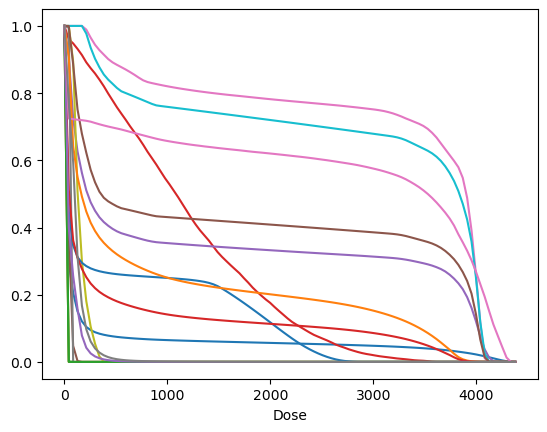

In [123]:
# for cumulative DVH
volumes = dose_table.loc[0,:]
volumes.T
relative_vol_dvh = dose_table.div(volumes)

ax = relative_vol_dvh.plot(legend=False)

## A Differential DVH curve set

In [124]:
diff_dvh_text = diff_dvh.read_text(encoding='utf_8_sig').splitlines()
dvh_info_section.read(diff_dvh_text)

{'Patient Name': 'EARR',
 'Patient ID': 'TEST EARR',
 'Comment': 'DVHs for one plan',
 'Date': 'March 22, 2023 8:18:16 AM',
 'Exported by': 'Gregory Salomons MP',
 'Type': 'Differential Dose Volume Histogram'}

In [125]:
context = {}
plans = all_plans.read(diff_dvh_text, context=context)
context['PlanLookup']

,,Plan Status,Prescribed dose,Prescribed dose unit,Prescription Isodose,DoseConversion
Course,Plan,,,,,
C2,EARR,Completed,6400.0,cGy,100.0,64.0


In [126]:
combined_data = dvh_dose.read(diff_dvh_text, context=context)

In [127]:
structure_table = build_structure_table(combined_data, context)
structure_table

Volume  Equiv. Sphere Diam.  Dose Cover.  \
Course Plan Structure                                                    
C2     EARR BODY              5805.8                 22.3        100.0   
            BrainStem           30.3                  3.9        100.0   
            PRV5 BrainStem      70.3                  5.1        100.0   
            Cochlea L            1.3                  1.3        100.0   
            Cochlea R            0.4                  0.9        100.0   
            CTV                 13.2                  2.9        100.0   
            Lens L               0.1                  0.7        100.0   
            Brain             1365.5                 13.8        100.0   
            Wires                0.4                  0.9        100.0   
            Lens R               0.2                  0.7        100.0   
            OpticChiasm          0.5                  1.0        100.0   
            OpticNerve L         0.6                  1.1        100.0   
            OpticNerve R         0.8                  1.1        100.0   
            PRV5 OpticNerve     21.3                  3.4        100.0   
            Globe L              7.2                  2.4        100.0   
            Globe R              7.3                  2.4        100.0   
            PTV                 47.0                  4.5        100.0   
            eval PTV            17.2                  3.2        100.0   
            opt PTV             38.3                  4.2        100.0   
            SpinalCanal         20.7                  3.4        100.0   
            PRV5 SpinalCanal    62.0                  4.9        100.0   
            Normal Tissue     5770.6                 22.3        100.0   
            Mandible            69.1                  5.1        100.0   
            Parotid B           40.0                  4.2        100.0   
            Parotid L           19.4                  3.3        100.0   
            Parotid R           20.6                  3.4        100.0   
            Bolus in Ear         3.1                  1.8        100.0   

                              Sampling Cover.  Max Dose  Min Dose  Mean Dose  \
Course Plan Structure                                                          
C2     EARR BODY                        100.0    6841.6       0.0      313.6   
            BrainStem                   100.0    1241.6     275.2      652.8   
            PRV5 BrainStem              100.0    1561.6     108.8      672.0   
            Cochlea L                   100.1     384.0     230.4      294.4   
            Cochlea R                   100.0    1977.6     921.6     1196.8   
            CTV                         100.0    6700.8    6361.6     6502.4   
            Lens L                      102.2     288.0     185.6      243.2   
            Brain                       100.0    4966.4      12.8      313.6   
            Wires                       101.3    6726.4    3692.8     6310.4   
            Lens R                      100.7     313.6     102.4      192.0   
            OpticChiasm                 100.1     614.4     281.6      422.4   
            OpticNerve L                100.0     531.2     179.2      320.0   
            OpticNerve R                 99.0     582.4     204.8      364.8   
            PRV5 OpticNerve             100.1     787.2     108.8      364.8   
            Globe L                     100.1     364.8      76.8      236.8   
            Globe R                     100.1     678.4      51.2      236.8   
            PTV                         100.0    6841.6    4761.6     6470.4   
            eval PTV                     99.9    6841.6    6054.4     6515.2   
            opt PTV                     100.0    6841.6    5881.6     6502.4   
            SpinalCanal                 100.0    1350.4      12.8      320.0   
            PRV5 SpinalCanal            100.0    1568.0      12.8      313.6   
            Normal Tissue               100

In [128]:
dose_table = build_dvh_curves(combined_data, context)
dose_table

Course            C2                                                           \
Plan            EARR                                                            
Structure       BODY BrainStem PRV5 BrainStem Cochlea L Cochlea R  CTV Lens L   
Dose                                                                            
3.2        91.050313       0.0            0.0       0.0       0.0  0.0    0.0   
9.6        94.974375       0.0            0.0       0.0       0.0  0.0    0.0   
16.0       95.305469       0.0            0.0       0.0       0.0  0.0    0.0   
22.4       72.126563       0.0            0.0       0.0       0.0  0.0    0.0   
28.8       54.498281       0.0            0.0       0.0       0.0  0.0    0.0   
...              ...       ...            ...       ...       ...  ...    ...   
6819.2      0.000080       0.0            0.0       0.0       0.0  0.0    0.0   
6825.6      0.000080       0.0            0.0       0.0       0.0  0.0    0.0   
6832.0      0.000080       0.0            0.0       0.0       0.0  0.0    0.0   
6838.4      0.000080       0.0            0.0       0.0       0.0  0.0    0.0   
6844.8      0.000033       0.0            0.0       0.0       0.0  0.0    0.0   

Course                             ...                                  \
Plan                               ...                                   
Structure      Brain Wires Lens R  ...  eval PTV   opt PTV SpinalCanal   
Dose                               ...                                   
3.2         0.000000   0.0    0.0  ...  0.000000  0.000000    0.000000   
9.6         1.140025   0.0    0.0  ...  0.000000  0.000000    0.000000   
16.0       17.335625   0.0    0.0  ...  0.000000  0.000000    0.214520   
22.4       22.529375   0.0    0.0  ...  0.000000  0.000000    0.283919   
28.8       18.882812   0.0    0.0  ...  0.000000  0.000000    0.237303   
...              ...   ...    ...  ...       ...       ...         ...   
6819.2      0.000000   0.0    0.0  ...  0.000028  0.000028    0.000000   
6825.6      0.000000   0.0    0.0  ...  0.000028  0.000028    0.000000   
6832.0      0.000000   0.0    0.0  ...  0.000012  0.000012    0.000000   
6838.4      0.000000   0.0    0.0  ...  0.000009  0.000009    0.000000   
6844.8      0.000000   0.0    0.0  ...  0.000004  0.000004    0.000000   

Course                                                                  \
Plan                                                                     
Structure PRV5 SpinalCanal Normal Tissue  Mandible Parotid B Parotid L   
Dose                                                                     
3.2               0.000000     97.655625  0.000000  0.000000  0.000000   
9.6               0.000000     95.096563  0.414723  0.000000  0.000000   
16.0              1.100223     95.335781  1.691844  0.000000  0.000000   
22.4              0.947975     72.131563  1.699922  0.000000  0.000000   
28.8              0.745553     54.497500  1.156386  0.044188  0.044212   
...                    ...           ...       ...       ...       ...   
6819.2            0.000000      0.000000  0.000000  0.000000  0.000000   
6825.6            0.000000      0.000000  0.000000  0.000000  0.000000   
6832.0            0.000000      0.000000  0.000000  0.000000  0.000000   
6838.4            0.000000      0.000000  0.000000  0.000000  0.000000   
6844.8            0.000000      0.000000  0.000000  0.000000  0.000000   

Course                            
Plan                              
Structure Parotid R Bolus in Ear  
Dose                              
3.2             0.0          0.0  
9.6             0.0          0.0  
16.0            0.0          0.0  
22.4            0.0          0.0  
28.8            0.0          0.0  
...             ...          ...  
6819.2          0.0          0.0  
6825.6          0.0          0.0  
6832.0          0.0          0.0  
6838.4          0.0          0.0  
6844.8          0.0          0.0  

[1070 rows x 27 columns]

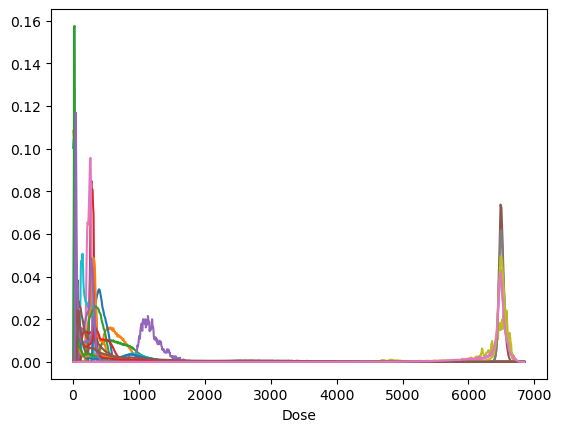

In [129]:
# for differential DVH
volumes = dose_table.apply(sum)
volumes.T

relative_vol_dvh = dose_table.div(volumes)
ax = relative_vol_dvh.plot(legend=False)

In [130]:
def build_structure_table(structure_data_list: List[Dict[str, Any]], 
                          context: Dict[str, Any])->pd.DataFrame:
    structure_data = pd.DataFrame(structure_data_list)

    index_columns = ['Course', 'Plan', 'Structure']
    unit_columns = [col for col in structure_data.columns if 'unit' in col]

    structure_table = structure_data.drop(columns=unit_columns)
    structure_table.set_index(index_columns, inplace=True)

    unit_conversion, data_units = convert_units(structure_data, unit_columns, 
                                                index_columns, context)
    structure_table = structure_table * unit_conversion
    structure_table.drop(columns=['Approval Status', 'Dose Level'], 
                         inplace=True)

    structure_table.sort_index(axis='columns', key=column_sort, inplace=True)
    return structure_table

In [131]:
def build_curve(dt, context):
    # Convert the list of lists to a 2D numpy array so that columns can be 
    # extracted easier.
    dvh_data = np.array(dt['DVH Curve'])
    # Construct an index for the curve
    header_dict = {
        'Course': dt['Structure']['Course'],
        'Plan': dt['Structure']['Plan'],
        'Structure': dt['Structure']['Structure']
    }
    # Get the curve header info to locate the desired data columns.
    hdr = dt['Header'][0]

    # Locate the dose column in absolute dose units.  
    # Exclude columns with a label containing 'dDose' because Delta volume 
    # columns may also have Gy or cGy in the units.
    # Note: This assumes that there there always will be a Dose column in 
    # absolute units.
    dose_idx = [i for i,h in enumerate(hdr) 
                if ('Gy' in h[1]) & ('dDose' not in h[0])][0]
    # Put the dose units (Gy or cGy) into the context dictionary.
    context['Dose Unit'] = hdr[dose_idx][1]
    
    vol_idx = [i for i,h in enumerate(hdr) if 'volume' in h[0].lower()][0]
    dvh_data, vol_unit = convert_volume(dvh_data, vol_idx, hdr,
                                        dt, header_dict, context)
    context['Volume Unit'] = vol_unit
    
    col_idx = [dose_idx, vol_idx]
    curve = pd.DataFrame(dvh_data[:,col_idx], columns = ['Dose', 'Volume'])
    curve.set_index('Dose', inplace=True)

    struct_idx = [(header_dict['Course'], 
                   header_dict['Plan'],
                   header_dict['Structure'])]
    idx_names = ['Course', 'Plan', 'Structure']
    curve.columns = pd.MultiIndex.from_tuples(struct_idx, names=idx_names)
    return curve

In [132]:
def build_dvh_tables(combined_data: List[Dict[str, Any]], 
                     context: Dict[str, Any])->pd.DataFrame:
    curve_list = []
    structure_data_list = []
    for dt in combined_data:
        structure_data_list.append(dt['Structure'])
        curve = build_curve(dt, context)
        curve_list.append(curve)

    dose_table = pd.concat(curve_list, axis='columns')
    structure_table = build_structure_table(structure_data_list, context)
    dvh_tables = {
        'StructureTable': structure_table,
        'DVH_Curves': dose_table
        }
    return dvh_tables

In [133]:
dvh_dose = Section(
    name='DVH Dose',
    start_search=('Structure:', 'START', 'Before'),
    processor=[(dose_info_section, 
                dose_header_section, 
                dose_curve_section)],
    assemble=build_dvh_tables
    )


In [134]:
def get_dvh_info(dvh_section_iter: List[Dict[str,Any]], 
                 context: Dict[str,Any])->Dict[str,Any]:
    # Only one dvh_file_reader in a file 
    dvh_sections = [ dvh_dict for dvh_dict in dvh_section_iter][0]
    dvh_info = dvh_sections['Information']
    dvh_info['Dose Unit'] = context['Dose Unit']
    dvh_info['Volume Unit'] = context['Volume Unit']
    
    dvh_tables = {'Plans': context['PlanLookup'],
                  'Structures': dvh_sections['DVH Dose']['StructureTable'],
                  'DVH_data': dvh_sections['DVH Dose']['DVH_Curves']
                  }
    return  dvh_info, dvh_tables

In [141]:
dvh_file_reader = Section(
    name='DVH File',
    processor=[(dvh_info_section, 
                all_plans, 
                dvh_dose)],
    assemble=get_dvh_info
    )

In [142]:
demo_dvh_text = demo_dvh_1.read_text(encoding='utf_8_sig').splitlines()
context = {'Dummy': 'test'}
dvh_info, dvh_tables = dvh_file_reader.read(demo_dvh_text, context=context)

In [143]:
dvh_info

{'Patient Name': 'AXIR, CHWR',
 'Patient ID': 'TEST CHWR',
 'Comment': 'DVHs for one plan',
 'Date': 'March 17, 2023 11:40:38 AM',
 'Exported by': 'GS MP',
 'Type': 'Cumulative Dose Volume Histogram',
 'Dose Unit': 'cGy',
 'Volume Unit': 'cm³'}

In [144]:
dvh_tables.keys()

dict_keys(['Plans', 'Structures', 'DVH_data'])

In [145]:
dvh_tables['Plans']

,,Plan Status,Prescribed dose,Prescribed dose unit,Prescription Isodose,DoseConversion
Course,Plan,,,,,
C1,CHWR,Completed,4250.0,cGy,100.0,42.5


In [146]:
dvh_tables['Structures']

Volume  Equiv. Sphere Diam.  Dose Cover.  \
Course Plan Structure                                                     
C1     CHWR BODY              20449.1                 33.9        100.0   
            Cricoid               4.2                  2.0        100.0   
            Spinal Canal         16.2                  3.1        100.0   
            Scar Wire             0.2                  0.7        100.0   
            PTV Nodes           197.9                  7.2        100.0   
            Nodes SC             10.2                  2.7        100.0   
            Nodes IMC             1.5                  1.4        100.0   
            Nodes Axilla III      5.0                  2.1        100.0   
            Nodes Axilla II      24.7                  3.6        100.0   
            Nodes Axilla I       39.1                  4.2        100.0   
            Matchplane           71.0                  5.1        100.0   
            Lung R              950.7                 12.2        100.0   
            Lung L              737.0                 11.2        100.0   
            Lung B             1687.7                 14.8        100.0   
            Heart               492.7                  9.8        100.0   
            CTV Nodes            70.7                  5.1        100.0   
            Baseline             52.4                  4.6        100.0   
            Liver              1174.7                 13.1        100.0   

                              Sampling Cover.  Max Dose  Min Dose  Mean Dose  \
Course Plan Structure                                                          
C1     CHWR BODY                        100.0   4394.50      0.00     263.50   
            Cricoid                      99.8     21.25      8.50      12.75   
            Spinal Canal                100.0     29.75      4.25      17.00   
            Scar Wire                   100.7   3791.00      0.00    1181.50   
            PTV Nodes                   100.0   4233.00     17.00    1406.75   
            Nodes SC                    100.0    157.25     21.25      42.50   
            Nodes IMC                    99.8   4097.00    165.75    3132.25   
            Nodes Axilla III            100.1     72.25     42.50      55.25   
            Nodes Axilla II             100.0    403.75     63.75     153.00   
            Nodes Axilla I              100.0   4143.75    182.75    2898.50   
            Matchplane                  100.0   2902.75      0.00     527.00   
            Lung R                      100.0   4088.50     17.00     871.25   
            Lung L                      100.0     55.25      0.00       8.50   
            Lung B                      100.0   4088.50      0.00     493.00   
            Heart                       100.0   1423.75      0.00      63.75   
            CTV Nodes                   100.0   4143.75     42.50    1704.25   
            Baseline                    100.0   4339.25      0.00    2452.25   
            Liver                       100.0   2928.25      8.50     114.75   

                              Median Dose  Modal Dose      STD  ...  \
Course Plan Structure                                           ...   
C1     CHWR BODY                    12.75        0.00   862.75  ...   
            Cricoid                 12.75       12.75     0.00  ...   
            Spinal Canal            17.00        4.25     8.50  ...   
            Scar Wire             1083.75        0.00   799.00  ...   
            PTV Nodes              225.25       42.50  1729.75  ...   
            Nodes SC                38.25       25.50    21.25  ...   
            Nodes IMC             3901.50     4020.50  1372.75  ...   
            Nodes Axilla III        55.25       51.00     8.50  ...   
            Nodes Axilla II        127.50       93.50    68.00  ...   
            Nodes Axilla I        3833.50     4012.00  1513.00  ...   
            Matchplane              29.75        0.00   858.50  ...   
      

In [147]:
dvh_tables['DVH_data']

Course               C1                                                        \
Plan               CHWR                                                         
Structure          BODY Cricoid Spinal Canal Scar Wire   PTV Nodes   Nodes SC   
Dose                                                                            
0.0        20449.100000     4.2         16.2  0.200000  197.900000  10.200000   
42.5        6045.510577     0.0          0.0  0.192057  179.526172   3.882589   
85.0        4212.719091     0.0          0.0  0.189588  143.680941   0.487524   
127.5       3077.487304     0.0          0.0  0.186312  123.950707   0.028369   
170.0       2469.310621     0.0          0.0  0.182694  111.347643   0.000000   
...                 ...     ...          ...       ...         ...        ...   
4207.5       153.745331     0.0          0.0  0.000000    0.016353   0.000000   
4250.0        93.274889     0.0          0.0  0.000000    0.000000   0.000000   
4292.5        42.371149     0.0          0.0  0.000000    0.000000   0.000000   
4335.0         8.423557     0.0          0.0  0.000000    0.000000   0.000000   
4377.5         0.423192     0.0          0.0  0.000000    0.000000   0.000000   

Course                                                               \
Plan                                                                  
Structure Nodes IMC Nodes Axilla III Nodes Axilla II Nodes Axilla I   
Dose                                                                  
0.0        1.500000         5.000000       24.700000           39.1   
42.5       1.500000         4.974855       24.700000           39.1   
85.0       1.500000         0.000000       22.078515           39.1   
127.5      1.500000         0.000000       12.538930           39.1   
170.0      1.499939         0.000000        7.424005           39.1   
...             ...              ...             ...            ...   
4207.5     0.000000         0.000000        0.000000            0.0   
4250.0     0.000000         0.000000        0.000000            0.0   
4292.5     0.000000         0.000000        0.000000            0.0   
4335.0     0.000000         0.000000        0.000000            0.0   
4377.5     0.000000         0.000000        0.000000            0.0   

Course                                                                 \
Plan                                                                    
Structure Matchplane      Lung R      Lung L       Lung B       Heart   
Dose                                                                    
0.0        71.000000  950.700000  737.000000  1687.700000  492.700000   
42.5       31.785493  863.832640    1.029515   864.809546  197.372664   
85.0       24.654608  610.848518    0.000000   610.812384  126.288371   
127.5      22.132049  523.138837    0.000000   523.107678   77.816545   
170.0      20.945923  468.126581    0.000000   468.098784   38.734152   
...              ...         ...         ...          ...         ...   
4207.5      0.000000    0.000000    0.000000     0.000000    0.000000   
4250.0      0.000000    0.000000    0.000000     0.000000    0.000000   
4292.5      0.000000    0.000000    0.000000     0.000000    0.000000   
4335.0      0.000000    0.000000    0.000000     0.000000    0.000000   
4377.5      0.000000    0.000000    0.000000     0.000000    0.000000   

Course                                        
Plan                                          
Structure  CTV Nodes   Baseline        Liver  
Dose                                          
0.0        70.700000  52.400000  1174.700000  
42.5       70.676457  37.986018   904.260566  
85.0       62.641119  37.859157   699.472766  
127.5      53.115284  37.771387   367.701070  
170.0      48.010673  37.700228   197.092341  
...              ...        ...          ...  
4207.5      0.000000   4.084669     0.000000  
4250.0      0.000000   2.356894     0.000000  
4292.5      0.000000   0.681378     0.000000  
4335.0     

In [150]:
multi_dvh_text = multi_dvh.read_text(encoding='utf_8_sig').splitlines()
dvh_info, dvh_tables = dvh_file_reader.read(multi_dvh_text, context=context)


In [151]:
dvh_info

{'Patient Name': 'Replan',
 'Patient ID': 'Test Replan',
 'Comment': 'DVHs for multiple plans and plan sums',
 'Date': 'January 1, 2022 12:00:00 PM',
 'Exported by': 'GS MP',
 'Type': 'Cumulative Dose Volume Histogram',
 'Dose Unit': 'cGy',
 'Volume Unit': 'cm³'}

In [152]:
dvh_tables.keys()

dict_keys(['Plans', 'Structures', 'DVH_data'])

In [153]:
dvh_tables['Plans']

Plan Status  Prescribed dose Prescribed dose unit  \
Course      Plan                                                              
NOT TREATED ORBR2-Ref4Gy     Rejected           2000.0                  cGy   
            ORBR-0.5cmBol    Rejected           2000.0                  cGy   
            ORBR3-ref2cm     Rejected           2000.0                  cGy   

                           Prescription Isodose  DoseConversion  
Course      Plan                                                 
NOT TREATED ORBR2-Ref4Gy                  100.0            20.0  
            ORBR-0.5cmBol                 100.0            20.0  
            ORBR3-ref2cm                  100.0            20.0

In [154]:
dvh_tables['Structures']

Volume  Equiv. Sphere Diam.  \
Course      Plan          Structure                                       
NOT TREATED ORBR-0.5cmBol Avoid Normal      3123.2                 18.1   
                          BODY             20081.5                 33.7   
                          Brain             1515.7                 14.3   
                          BrainStem           30.1                  3.9   
                          CTV                 22.3                  3.5   
                          Day 1 Body        4592.3                 20.6   
                          Dose 105[%]         11.7                  2.8   
                          GTV                 22.2                  3.5   
                          Globe L              7.4                  2.4   
                          Globe R              7.2                  2.4   
                          Lens L               0.3                  0.8   
                          Lens R               0.2                  0.8   
                          OpticChiasm          1.1                  1.3   
                          OpticNerve L         0.7                  1.1   
                          OpticNerve R         0.6                  1.0   
                          PRV 5BrainStem      71.9                  5.2   
                          PTV 20/5            41.4                  4.3   
                          SpinalCanal         39.4                  4.2   
                          eval PTV            37.0                  4.1   
            ORBR2-Ref4Gy  BODY             20093.2                 33.7   
                          Brain             1515.7                 14.3   
                          BrainStem           30.1                  3.9   
                          CTV                 22.3                  3.5   
                          Day 1 Body        4592.3                 20.6   
                          Fill in density     11.0                  2.8   
                          GTV                 22.2                  3.5   
                          Globe L              7.4                  2.4   
                          Globe R              7.2                  2.4   
                          Lens L               0.3                  0.8   
                          Lens R               0.2                  0.8   
                          OpticChiasm          1.1                  1.3   
                          OpticNerve L         0.7                  1.1   
                          OpticNerve R         0.6                  1.0   
                          PRV 5BrainStem      71.9                  5.2   
                          PTV 20/5            41.4                  4.3   
                          SpinalCanal         39.4                  4.2   
                          eval PTV            37.0                  4.1   
            ORBR3-ref2cm  Avoid Normal      3198.4                 18.3   
                          BODY             17410.4                 32.2   
                          Brain             1511.0                 14.2   
                          BrainStem           30.0                  3.9   
                          CTV                 35.1                  4.1   
                          Dose 105[%]         26.2                  3.7   
                          GTV                 35.3                  4.1   
                          Globe L              7.0                  2.4   
                          Globe R              7.4                  2.4   
                          Lens L               0.3                  0.8   
                          Lens R               0.2                  0.8   
                          ORBR 10Gy          164.3                  6.8   
                          OpticChiasm          1.1                  1.3   
                          OpticNerve L         0.9                  1.2   
                          OpticNerve R         0.9                  1

In [155]:
dvh_tables['DVH_data']

Course      NOT TREATED                                                       \
Plan       ORBR2-Ref4Gy                                                        
Structure          BODY        Brain  BrainStem PRV 5BrainStem Lens L Lens R   
Dose                                                                           
0.0        20093.200000  1515.700000  30.100000      71.900000    0.3    0.2   
1.0         4500.937080  1164.441072  30.100000      71.900000    0.3    0.2   
2.0         3724.676484   951.806550  30.100000      71.298341    0.3    0.2   
3.0         3033.269472   765.861990  28.712932      63.785222    0.3    0.2   
4.0         2550.369596   634.512944  23.479806      48.192916    0.3    0.2   
...                 ...          ...        ...            ...    ...    ...   
2163.0         0.000000     0.000000   0.000000       0.000000    0.0    0.0   
2164.0         0.000000     0.000000   0.000000       0.000000    0.0    0.0   
2165.0         0.000000     0.000000   0.000000       0.000000    0.0    0.0   
2166.0         0.000000     0.000000   0.000000       0.000000    0.0    0.0   
2167.0         0.000000     0.000000   0.000000       0.000000    0.0    0.0   

Course                                                   ...               \
Plan                                                     ... ORBR3-ref2cm   
Structure OpticChiasm OpticNerve L OpticNerve R Globe L  ...       Lens R   
Dose                                                     ...                
0.0               1.1          0.7          0.6     7.4  ...          0.2   
1.0               1.1          0.7          0.6     7.4  ...          0.2   
2.0               1.1          0.7          0.6     7.4  ...          0.2   
3.0               1.1          0.7          0.6     7.4  ...          0.2   
4.0               1.1          0.7          0.6     7.4  ...          0.2   
...               ...          ...          ...     ...  ...          ...   
2163.0            0.0          0.0          0.0     0.0  ...          0.0   
2164.0            0.0          0.0          0.0     0.0  ...          0.0   
2165.0            0.0          0.0          0.0     0.0  ...          0.0   
2166.0            0.0          0.0          0.0     0.0  ...          0.0   
2167.0            0.0          0.0          0.0     0.0  ...          0.0   

Course                                                                     \
Plan                                                                        
Structure OpticChiasm OpticNerve L OpticNerve R PRV 5BrainStem   PTV 20/5   
Dose                                                                        
0.0               1.1          0.9          0.9           69.6  74.300000   
1.0               1.1          0.9          0.9           69.6  74.300000   
2.0               1.1          0.9          0.9           69.6  74.300000   
3.0               1.1          0.9          0.9           69.6  74.300000   
4.0               1.1          0.9          0.9           69.6  74.300000   
...               ...          ...          ...            ...        ...   
2163.0            0.0          0.0          0.0            0.0   0.002166   
2164.0            0.0          0.0          0.0            0.0   0.001491   
2165.0            0.0          0.0          0.0            0.0   0.000874   
2166.0            0.0          0.0          0.0            0.0   0.000456   
2167.0            0.0          0.0          0.0            0.0   0.000084   

Course                                                      
Plan                                                        
Structure SpinalCanal Avoid Normal Dose 105[%]   ORBR 10Gy  
Dose                                                        
0.0         38.600000  3198.400000        26.2  164.300000  
1.0         28.731717  3198.400000        26.2  164.300000  
2.0         23.019149  3198.400000        26.2  164.300000  
3.0         20.087594  3198.364818        26.2  164.300000  

## Next Steps
1. Clean up documentation
2. Export to .py 

## ToDo
- Create relative volume and relative dose conversion functions
- Create function to return DVH point value
- Create functions and GUI for interactive DVH plotting
- Create functions for exporting DVH data to spreadsheet tables